# Projet — Football : données volumineuses & analyses - Celine BENDEKOUM M1 2SIA

## Objectif
L’objectif de ce projet est de construire un **outil de suivi de performance** exploitable par un club (entraîneur, préparateur physique, analyste) à partir de données GPS/IMU.

Concrètement, on veut pouvoir répondre de façon **rapide, traçable et comparable** à des questions comme :
- **Quelle est la charge d’un match / d’un entraînement ?** (volume + intensité)
- **Comment la charge évolue dans le temps ?** (tendances, pics, semaines chargées)
- **Quels postes / quels joueurs sont le plus exposés aux efforts intenses ?**
- **Quelles séances sont atypiques** (trop faibles / trop intenses / données suspectes) ?
- **Comment deux joueurs se comparent** à rôle différent, et **par rapport à leurs propres habitudes** (normalisation) ?

## But opérationnel (outil de suivi)
Le pipeline doit fonctionner comme un **système de monitoring** :
- **Standardiser** toutes les séances (game/practice) dans une base unique.
- Permettre des **requêtes SQL réutilisables** (mêmes KPI, mêmes définitions, mêmes filtres).
- Produire des **sorties lisibles** pour le staff : tableaux + graphiques + alertes simples (outliers).
- Garantir un minimum de **qualité de données** (valeurs impossibles, incohérences, NA, etc.) pour éviter des décisions basées sur du bruit.

## Sources de données
On utilise 2 niveaux complémentaires :
- **Tracking brut** (fichiers par capteur, par séance) : positions/vitesse au cours du temps → utile pour analyses intra-séance (phases, pics, répétitions).
- **summary.csv** : un résumé “joueur-séance” déjà agrégé (distance, zones de vitesse, accélérations/décélérations, vitesses max, etc.) → idéal pour le monitoring global et les comparaisons.

## Livrable technique
Construire une base **DuckDB** interrogable en SQL, contenant :
- **Ingestion & normalisation** : import robuste, typage, harmonisation des colonnes.
- **Contrôles qualité** : règles simples (valeurs non plausibles, distances nulles, vitesses max aberrantes, cohérence zones vs distance totale).
- **Vues SQL réutilisables** : vues “clean” (prêtes pour l’analyse), dimensions joueurs, vues de KPI (ex : HID, ratios).

## Livrable analytique (rapport orienté staff)
Le rapport doit produire des analyses directement actionnables :
- **Global équipe (match)** : charge typique d’un match, variabilité, profils par poste.
- **Séance spécifique (match)** : une date précise (match très intense / très faible), profils joueurs.
- **Global équipe (entraînement)** : structure de la charge d’entraînement, comparaison vs match.
- **Séance spécifique (entraînement)** : séance “clé” (très intense vs légère).
- **Synthèse équipe** : tableaux “dashboard” game vs practice, et par poste.
- **Comparaison 2 joueurs** : profils athlétiques + KPI normalisés (par rapport à eux-mêmes).

## Organisation des analyses (plan de travail)
On avance du **global équipe** vers le **spécifique**, puis vers l’**individuel** :
1) Matchs — global équipe  
2) Matchs — séance(s) spécifique(s)  
3) Entraînements — global équipe  
4) Entraînements — séance(s) spécifique(s)  
5) Synthèse globale équipe (dashboard)  
6) Comparaison individuelle de 2 joueurs (profils + normalisation)

## Stack et méthode (logique “production”)
- Stockage/requêtes : **DuckDB** (tables + vues SQL)
- Manipulation : **pandas / numpy**
- Viz : **matplotlib / seaborn**
- Principe : **définir une fois les KPI et filtres**, les réutiliser partout (cohérence), puis produire des comparaisons (match vs entraînement, poste, joueur, période).


-----------------------------------------------------------------------------------------

### Préambule (pour le club / le staff)

Cette cellule met en place la **base de travail “fiable”** qui servira ensuite à toutes les analyses (matchs, entraînements, comparaisons joueurs).  
L’idée est la suivante : avant d’interpréter des KPI (distance, vitesses, sprints, accélérations), on doit **centraliser**, **standardiser** et **contrôler la qualité** des données pour éviter de tirer des conclusions sur des valeurs aberrantes ou incomplètes.

Concrètement, la cellule :
1) **Ouvre la base DuckDB** (`football.duckdb`) qui permet d’interroger les données en **SQL** comme dans une base “club” (rapide, reproductible).  
   - Si le fichier est verrouillé sous Windows (kernel Python déjà ouvert), on bascule temporairement en mémoire (`:memory:`) pour pouvoir continuer à travailler.

2) **Importe le fichier agrégé `summary.csv`** dans une table brute (`summary_raw`) en mode robuste :  
   - tout est lu comme texte (VARCHAR) et les valeurs manquantes (`NA`, `NaN`, etc.) deviennent `NULL`.  
   Objectif : **ne jamais bloquer l’import** à cause d’une valeur manquante ou d’un mauvais type.

3) Crée une vue `summary` **typée proprement** (numérique, dates, etc.) via `try_cast` :  
   - si une valeur est impossible à convertir, elle devient `NULL` au lieu de faire planter le pipeline.  
   Objectif : disposer d’un schéma stable pour calculer les KPI et comparer les séances/joueurs.

4) Crée une table `players` (dimension joueurs) :  
   - associe chaque capteur à un nom/prénom pour produire des résultats lisibles par le staff.

5) Crée une vue `summary_clean` = **données nettoyées**, prêtes pour le monitoring :  
   - on applique des règles simples et justifiables (ex : distance négative impossible, vitesse max irréaliste, joueur “non utilisé” en match avec distance trop faible, cohérence entre distance totale et somme des zones).  
   Objectif : produire une base “club-ready” où les graphiques et comparaisons reflètent de vrais comportements sportifs, pas des artefacts de capteur.

Enfin, un petit tableau récapitule combien de lignes/joueurs restent après nettoyage (game vs practice).  
C’est le point de départ de l’outil : **toutes les analyses suivantes utilisent `summary_clean`** pour garantir la cohérence et la qualité.

In [9]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

DB_PATH = Path("football.duckdb")

con = None  # Initialiser d'abord

# Ferme une éventuelle ancienne connexion (même kernel)
if "con" in globals() and con is not None:
    try:
        con.close()
    except Exception:
        pass

# Connexion DuckDB (fallback mémoire si verrou Windows)
try:
    con = duckdb.connect(str(DB_PATH))
except Exception as e:
    print("Warning: football.duckdb verrouillé/inaccessible -> fallback :memory:")
    print(e)
    con = duckdb.connect(database=":memory:")

con.execute("PRAGMA threads=4;")

# 1) Import brut robuste (tout en VARCHAR + NA->NULL)
con.execute("DROP TABLE IF EXISTS summary_raw;")
con.execute("""
CREATE TABLE summary_raw AS
SELECT *
FROM read_csv_auto(
  'data/data/summary.csv',
  header=true,
  all_varchar=true,
  nullstr=['NA','NaN','N/A','']
);
""")

# 2) Vue typée (try_cast => jamais d'erreur)
con.execute("""
CREATE OR REPLACE VIEW summary AS
SELECT
  try_cast("Sensor" AS INTEGER) AS sensor,
  upper("last_name") AS last_name,
  upper("first_name") AS first_name,
  try_cast("date" AS TIMESTAMP) AS session_ts,
  "type" AS session_type,
  "position" AS position,

  try_cast("feature_distance" AS DOUBLE) AS distance_km,
  try_cast("feature_avg_speed" AS DOUBLE) AS avg_speed_kmh,
  try_cast("feature_max_speed" AS DOUBLE) AS max_speed_kmh,
  try_cast("feature_max_acc" AS DOUBLE) AS max_acc_ms2,

  try_cast("feature_d_speed_0_5" AS DOUBLE) AS d_0_5_km,
  try_cast("feature_d_speed_5_10" AS DOUBLE) AS d_5_10_km,
  try_cast("feature_d_speed_10_15" AS DOUBLE) AS d_10_15_km,
  try_cast("feature_d_speed_15_21" AS DOUBLE) AS d_15_21_km,
  try_cast("feature_d_speed_21_24" AS DOUBLE) AS d_21_24_km,
  try_cast("feature_d_speed_24_30" AS DOUBLE) AS d_24_30_km,
  try_cast("feature_d_speed_over30" AS DOUBLE) AS d_over30_km,

  try_cast("feature_acc_3mss" AS DOUBLE) AS acc_3mss,
  try_cast("feature_dec_3mss" AS DOUBLE) AS dec_3mss
FROM summary_raw;
""")

# 3) Dimension joueurs
con.execute("""
CREATE OR REPLACE TABLE players AS
SELECT
  sensor,
  any_value(last_name) AS last_name,
  any_value(first_name) AS first_name
FROM summary
WHERE sensor IS NOT NULL
GROUP BY sensor;
""")

# 4) Nettoyage : vue summary_clean
# Règles simples et justifiables:
# - match: distance >= 0.5 km (sinon "joueur non utilisé"/artefact)
# - match: vmax <= 40 km/h (valeurs type 42.5 suspectes)
# - pas de valeurs négatives
# - cohérence: somme zones <= distance * 1.15 (tolérance)
MIN_MATCH_DISTANCE_KM = 0.5
MAX_MATCH_DISTANCE_KM = 20.0
MAX_MAX_SPEED_KMH = 40.0
ZONE_TOL = 1.15

con.execute(f"""
CREATE OR REPLACE VIEW summary_clean AS
WITH s AS (
  SELECT
    *,
    (coalesce(d_0_5_km,0) + coalesce(d_5_10_km,0) + coalesce(d_10_15_km,0) +
     coalesce(d_15_21_km,0) + coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) +
     coalesce(d_over30_km,0)) AS zones_sum_km
  FROM summary
)
SELECT *
FROM s
WHERE sensor IS NOT NULL
  AND session_ts IS NOT NULL
  AND session_type IN ('game','practice')

  AND (distance_km IS NULL OR distance_km >= 0)
  AND (max_speed_kmh IS NULL OR max_speed_kmh >= 0)
  AND (acc_3mss IS NULL OR acc_3mss >= 0)
  AND (dec_3mss IS NULL OR dec_3mss >= 0)

  AND (
    distance_km IS NULL
    OR zones_sum_km <= distance_km * {ZONE_TOL}
  )

  AND (
    session_type <> 'game'
    OR (
      distance_km BETWEEN {MIN_MATCH_DISTANCE_KM} AND {MAX_MATCH_DISTANCE_KM}
      AND (max_speed_kmh IS NULL OR max_speed_kmh <= {MAX_MAX_SPEED_KMH})
    )
  );
""")

display(con.sql("""
SELECT session_type, COUNT(*) AS n_rows, COUNT(DISTINCT sensor) AS n_sensors
FROM summary_clean
GROUP BY 1 ORDER BY 1;
""").df())

,session_type,n_rows,n_sensors
0,game,1011,29
1,practice,3030,29


## 1) Matchs — global équipe (game global) : 

### objectif

### Pourquoi cette partie existe (usage terrain)
Cette section correspond à la brique “**monitoring matchday**” d’un club : elle sert à **quantifier la charge réelle imposée par les jours de match** et à la rendre comparable dans le temps et entre joueurs/postes.

L’objectif n’est pas de “faire joli”, mais de produire des indicateurs actionnables pour le staff, par exemple :
- **Planification** : repérer les matchs très chargés → adapter les séances J+1 / J+2.
- **Prévention / gestion de charge** : identifier des profils très exposés (HID élevé, beaucoup d’accélérations/décélérations).
- **Compréhension du style de match** : match “lent” vs match “très intense” (zones de vitesse + HID ratio).
- **Équité de charge** : qui joue réellement / qui est peu utilisé (distances très faibles).
- **Benchmark** : définir ce qu’est un “match typique” pour l’équipe (médiane/IQR) et détecter les anomalies.

> Important : on travaille sur `summary_clean` (données contrôlées) pour éviter d’interpréter des valeurs impossibles (ex : vmax aberrante, distances incohérentes).

---

## Ce que fait le code (traduction “métier”)

### 1) Construction d’une base “joueur-match” (table `games_players`)
Le SQL extrait une ligne par **joueur × date de match** avec :
- **Volume total** : `distance_km`
- **Intensité** :
  - `max_speed_kmh` (vitesse max atteinte par le joueur)
  - `acc_3mss`, `dec_3mss` (nombre d’accélérations/décélérations >= 3 m/s²)
- **Répartition de la distance par zones de vitesse** (0–5, 5–10, …, >30 km/h)

Ce format “joueur-match” est la base standard de suivi : on peut ensuite agréger équipe, comparer postes, et faire des distributions.

### 2) Calcul HID (High-Intensity Distance) et HID ratio
Le code calcule :
- **HID (km)** = distance à haute intensité, ici **à partir de 21 km/h**  
  `hid_km = d_21_24 + d_24_30 + d_over30`
- **HID ratio** = part d’intensité dans la charge totale  
  `hid_ratio = hid_km / distance_km`

Interprétation staff :
- Deux joueurs peuvent avoir la même distance totale, mais un **HID ratio différent** → l’un a vécu un match plus “explosif/haut-intensité”.

### 3) Agrégation “équipe par match” (table `team_by_match`)
On agrège ensuite **tous les joueurs** du match pour obtenir un résumé équipe par date :
- `n_players` : combien de joueurs ont des données ce jour-là
- `team_distance_km` : somme des distances (volume collectif)
- `team_hid_km` et `team_hid_ratio` : intensité collective
- `team_acc_3mss`, `team_dec_3mss` : charge mécanique (changements de vitesse)
- `avg_player_max_speed_kmh` vs `max_player_max_speed_kmh` :
  - moyenne des vmax des joueurs (niveau général)
  - meilleure vmax du match (pic individuel)

---

## Comment lire les sorties (ce que chaque graphique apporte)

### A) Séries temporelles (4 graphes)
But : visualiser la **variabilité match-to-match**.
- **Distance totale équipe** : volume global (match “long/actif” vs match “faible”)
- **Part HID équipe** : intensité relative (match très intense même si distance moyenne)
- **Acc/Dec équipe** : “charge mécanique” (beaucoup de transitions, pressing, duels)
- **Vitesse max** :
  - si la vmax max est très haute mais la moyenne reste normale → 1–2 joueurs ont sprinté fort
  - si les deux montent → match globalement rapide

Usage concret : repérer des pics → ajuster récupération / entraînement.

### B) Barres empilées par zones de vitesse
But : comprendre *où* la distance est faite.
- Plus de 0–15 km/h = match plus “posé” (placement, circulation)
- Plus de 21+ km/h = match plus “haute intensité” (courses, transitions)

Le code agrège par mois si beaucoup de matchs : c’est utile pour voir des tendances de période (début/fin de saison).

### C) Distribution globale (médiane, IQR, top/bottom)
But : définir un **match type** et la dispersion.
- **Médiane** : valeur “typique” (plus robuste que la moyenne si outliers)
- **IQR** (Q3–Q1) : variabilité “normale”  
  → plus l’IQR est grand, plus les matchs sont hétérogènes en charge.

Top/bottom joueurs :
- **Top distance/HID** : joueurs les plus sollicités en match (souvent milieux/ailiers selon style)
- **Bottom distance** : peut refléter remplaçants, temps de jeu réduit, ou rôle spécifique  
  (à interpréter avec prudence : idéalement avec temps de jeu, non disponible ici)

### D) Boxplots par poste
But : objectiver les **différences structurelles de rôle**.
- Distance par poste : volume typique
- HID ratio par poste : intensité relative du rôle
- Vmax par poste : exposition aux sprints
- Acc/Dec par poste : charge mécanique

Usage staff : construire des références par poste (benchmark) et repérer un joueur “hors profil” (retour de blessure, changement de rôle, fatigue).

---

## Résultat attendu (outil de suivi)
À la fin de cette section, le club dispose de :
- une courbe “charge match” (volume + intensité + mécanique),
- une description du style de match via zones,
- des benchmarks joueurs/postes (médiane/IQR),
- des listes top/bottom utiles pour le staff.

C’est la base pour comparer ensuite l’entraînement au match (sections 3–5) et pour normaliser les profils individuels (section 6).

,session_date,n_players,team_distance_km,team_hid_km,team_acc_3mss,team_dec_3mss,avg_player_max_speed_kmh,max_player_max_speed_kmh,team_d_0_5_km,team_d_5_10_km,team_d_10_15_km,team_d_15_21_km,team_d_21_24_km,team_d_24_30_km,team_d_over30_km,team_hid_ratio
0,2019-07-09,18,112.54,4.41,770.0,973.0,28.236111,31.42,21.09,39.24,32.41,15.32,2.63,1.77,0.01,0.039186
1,2019-07-12,12,106.18,3.69,723.0,925.0,28.765833,32.45,23.55,36.86,29.10,12.98,2.16,1.45,0.08,0.034752
2,2019-07-20,13,102.01,3.39,693.0,817.0,29.000769,33.44,28.49,35.75,24.14,10.24,1.99,1.32,0.08,0.033232
3,2019-07-25,11,103.66,2.64,629.0,757.0,28.117273,30.46,25.50,40.67,24.45,10.39,1.60,1.02,0.02,0.025468
4,2019-07-28,16,122.23,4.41,791.0,852.0,25.213750,32.03,37.31,38.40,28.61,13.51,2.71,1.64,0.06,0.036080
5,2019-08-01,13,107.16,3.23,969.0,917.0,28.263077,33.09,23.61,39.09,28.81,12.38,1.94,1.26,0.03,0.030142
6,2019-08-04,13,109.35,2.96,589.0,840.0,28.306923,31.20,27.85,40.73,26.07,11.75,1.85,1.08,0.03,0.027069
7,2019-08-08,13,109.17,3.05,734.0,958.0,28.199231,30.04,24.39,40.13,29.73,11.91,1.80,1.25,0.00,0.027938
8,2019-08-11,13,108.30,3.94,726.0,775.0,29.700000,34.78,25.44,38.95,28.35,11.64,2.16,1.59,0.19,0.036380
9,2019-08-15,13,107.74,2.44,615.0,787.0,27.429231,30.92,30.67,40.22,25.51,8.89,1.59,0.83,0.02,0.022647


Nb matchs (clean): 73


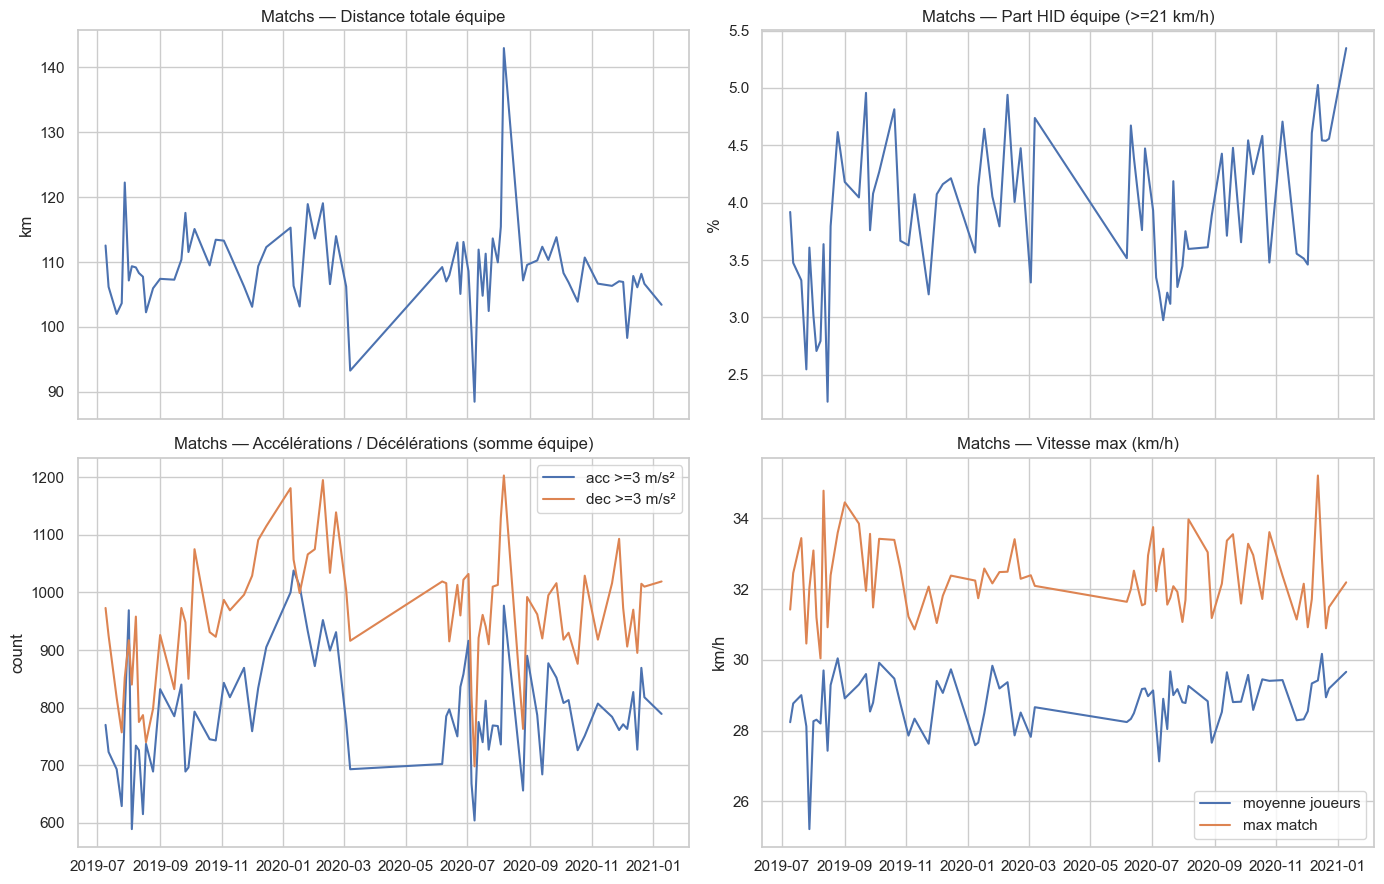

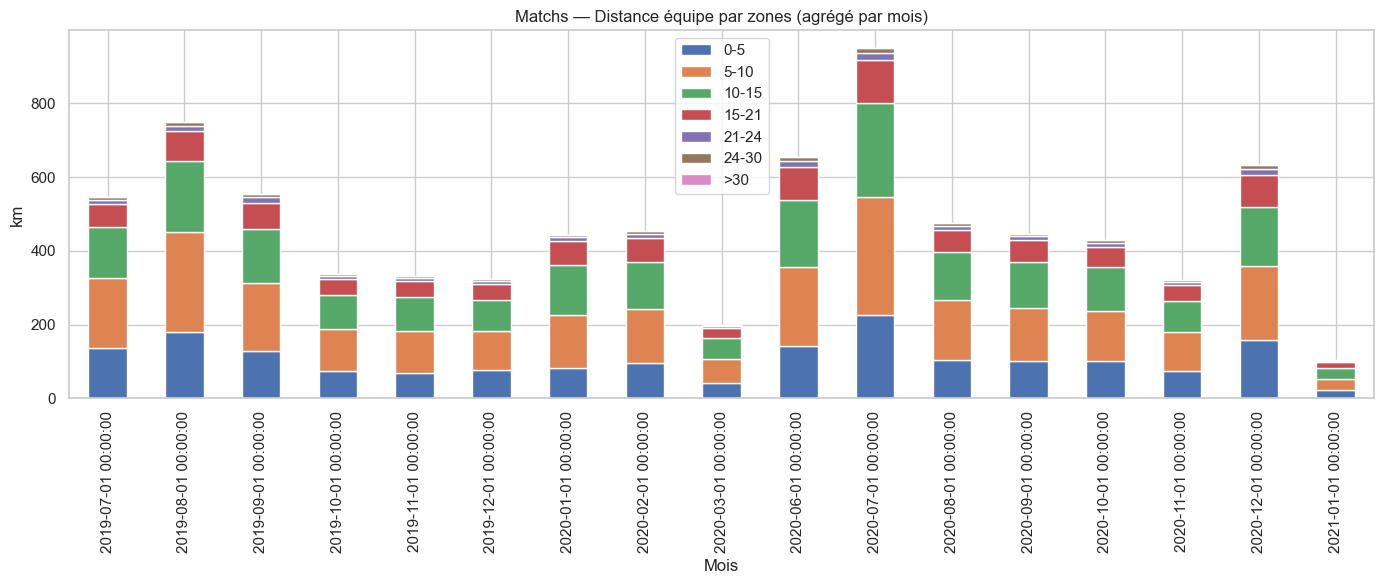

,n,median_distance_km,iqr_distance_km,median_hid_ratio,iqr_hid_ratio,median_max_speed,iqr_max_speed,median_acc,iqr_acc,median_dec,iqr_dec
distance_km,1011.0,8.91,5.675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hid_ratio,NaN,NaN,NaN,0.038113,0.02569,NaN,NaN,NaN,NaN,NaN,NaN
max_speed_kmh,NaN,NaN,NaN,NaN,NaN,28.78,2.835,NaN,NaN,NaN,NaN
acc_3mss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,41.0,NaN,NaN
dec_3mss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,51.0


Top 10 joueurs (distance moyenne par match):


,sensor,last_name,first_name,position,n_games,avg_distance_km,avg_hid_km,avg_max_speed_kmh
22,14,VOCA,IDRIZ,center midfield,51,10.374510,0.234902,27.068039
41,25,FRYDEK,MARTIN,artin left,11,9.900000,0.527273,29.458182
6,4,KNEZEVIC,STEFAN,center back,63,9.871111,0.272063,27.899206
17,10,ELEKE,BLESSING,center midfield,15,9.740667,0.425333,28.974667
24,15,SCHULZ,MARVIN,center midfield,57,9.626667,0.344211,28.590175
45,77,RYDER,MATOS,ilip center,19,9.325789,0.412105,29.321579
7,5,ALVES,LUCAS,center back,64,9.058281,0.232813,29.061094
20,12,SIDLER,SYLVAN,left back,65,8.976154,0.348308,29.389538
23,14,VOCA,IDRIZ,lex center,7,8.844286,0.200000,27.244286
26,17,GRETHER,SIMON,left forward,2,8.835000,0.555000,29.110000


Bottom 10 joueurs (distance moyenne par match):


,sensor,last_name,first_name,position,n_games,avg_distance_km,avg_hid_km,avg_max_speed_kmh
29,19,OWUSU,TYRON,left forward,5,1.968000,0.112000,26.926000
19,11,SCHURPF,PASCA,right back,1,2.900000,0.110000,27.090000
43,28,TIA,CHEF,center forward,24,3.239167,0.177917,27.562083
33,20,DEMHASAJ,MIMI,left forward,13,3.278462,0.191538,30.040769
0,0,BALATUBAN,ASH,left back,6,3.321667,0.166667,30.168333
32,20,DEMHASAJ,MIMI,center midfield,4,3.362500,0.137500,26.830000
10,6,ARNOLD,REMO,left back,7,3.472857,0.192857,28.294286
36,21,MALES,DARIAN,right midfield,8,3.883750,0.197500,29.328750
31,20,DEMHASAJ,MIMI,center forward,27,4.463704,0.186296,28.382593
8,6,ARNOLD,REMO,center forward,2,4.475000,0.250000,28.785000


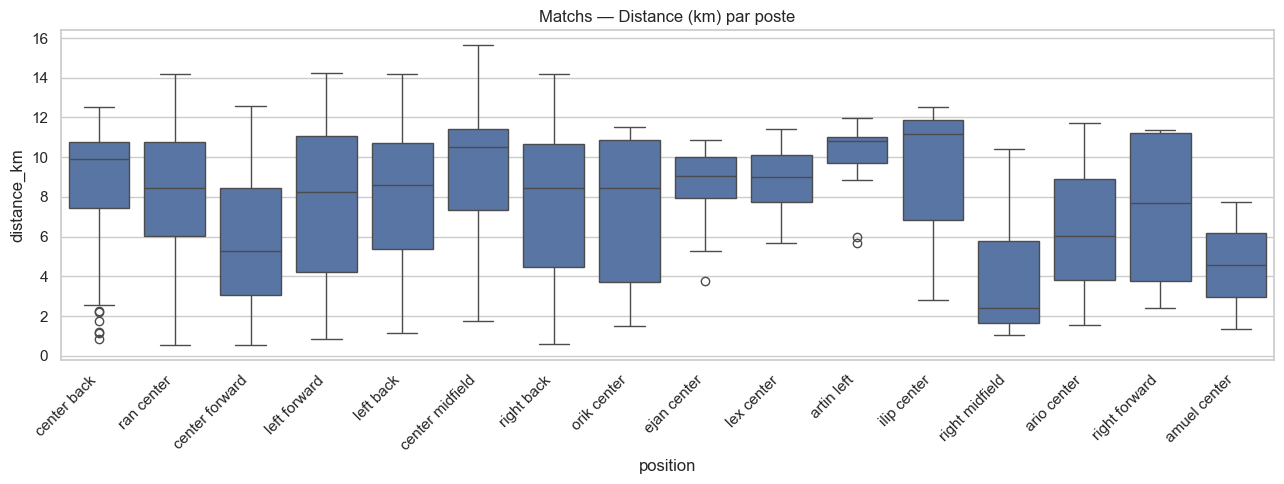

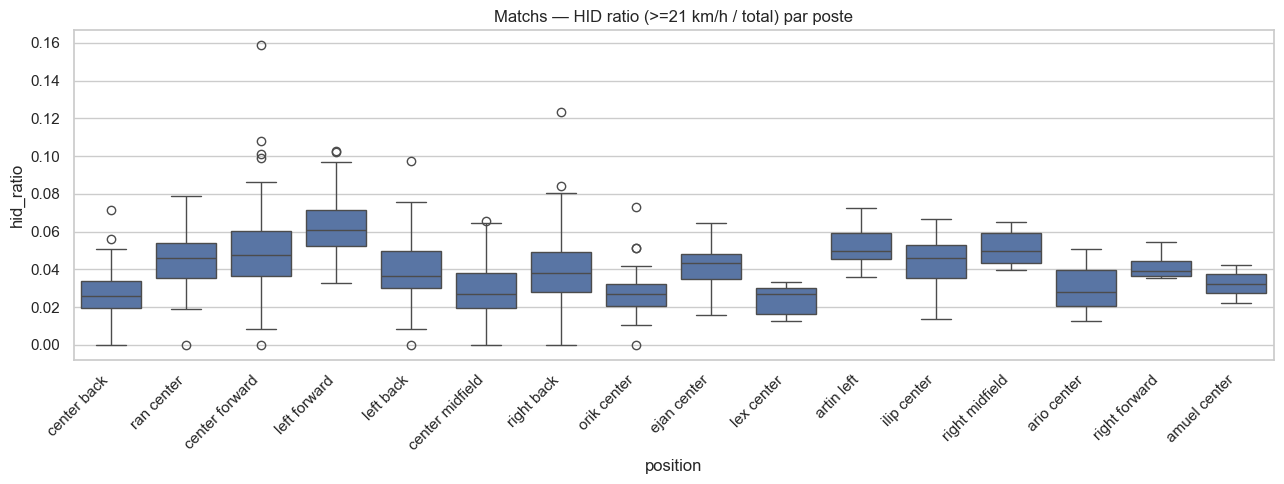

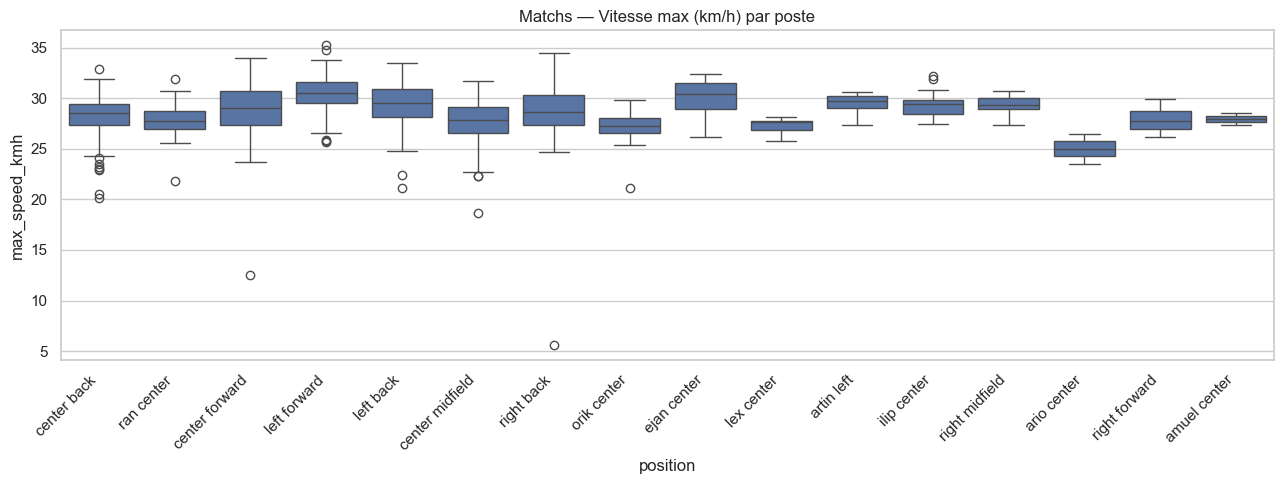

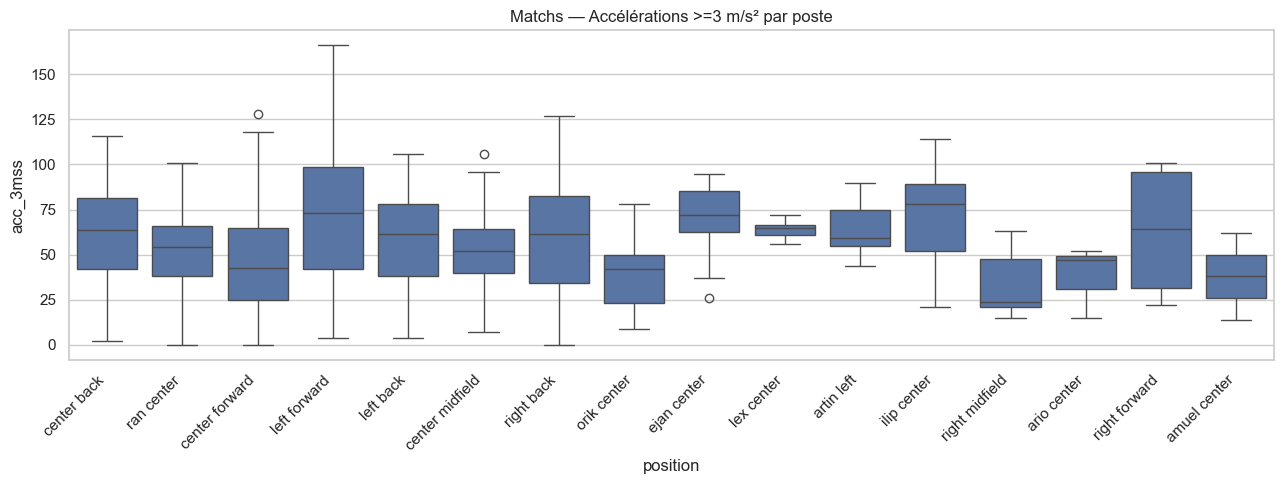

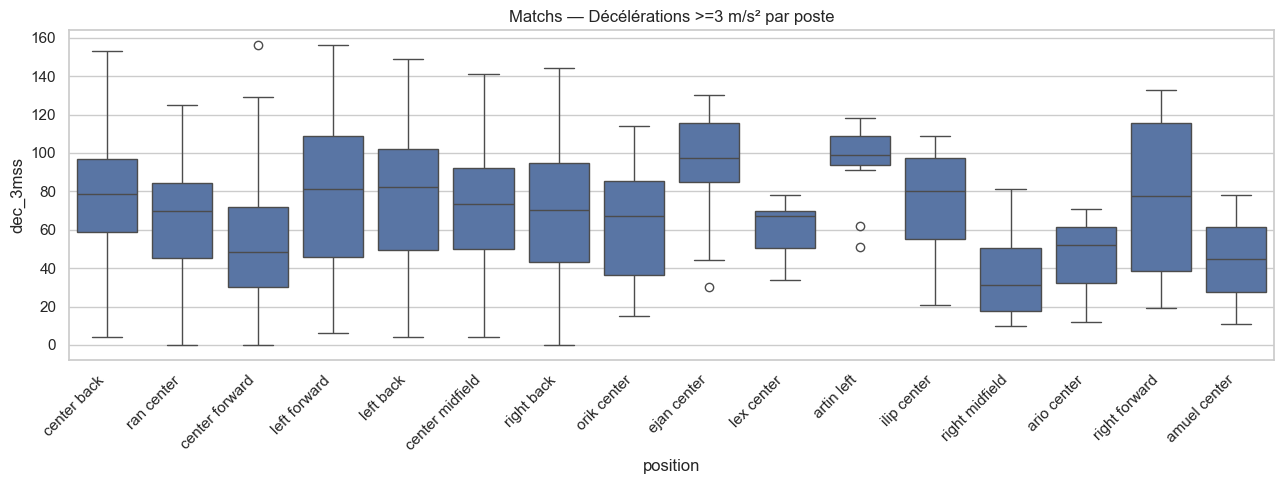

,position,n,median_distance_km,iqr_distance_km,median_hid_ratio,iqr_hid_ratio,median_max_speed,iqr_max_speed
0,ilip center,19,11.160,5.0050,0.046256,0.017430,29.450,1.3500
1,artin left,11,10.830,1.3450,0.049861,0.013620,29.670,1.1950
2,center midfield,168,10.520,4.0750,0.027102,0.018313,27.880,2.5375
3,center back,172,9.905,3.3550,0.026146,0.014123,28.485,2.0950
4,ejan center,14,9.075,2.0575,0.043301,0.013133,30.440,2.5675
5,lex center,7,9.000,2.3800,0.027098,0.013599,27.630,0.9450
6,left back,102,8.620,5.3325,0.036410,0.019627,29.530,2.7700
7,right back,122,8.475,6.1975,0.038079,0.021559,28.655,2.8875
8,ran center,52,8.470,4.7600,0.046127,0.018476,27.725,1.8375
9,orik center,27,8.440,7.1600,0.026882,0.011723,27.260,1.4500


In [10]:
from IPython.display import display

# ---------------------------
# 1) MATCHS — GLOBAL ÉQUIPE
# ---------------------------

# Base joueur-match nettoyée
games_players = con.sql("""
SELECT
  date_trunc('day', session_ts)::DATE AS session_date,
  sensor,
  position,
  distance_km,
  max_speed_kmh,
  coalesce(acc_3mss, 0) AS acc_3mss,
  coalesce(dec_3mss, 0) AS dec_3mss,

  coalesce(d_0_5_km, 0) AS d_0_5_km,
  coalesce(d_5_10_km, 0) AS d_5_10_km,
  coalesce(d_10_15_km, 0) AS d_10_15_km,
  coalesce(d_15_21_km, 0) AS d_15_21_km,
  coalesce(d_21_24_km, 0) AS d_21_24_km,
  coalesce(d_24_30_km, 0) AS d_24_30_km,
  coalesce(d_over30_km, 0) AS d_over30_km
FROM summary_clean
WHERE session_type='game';
""").df()

# HID (>=21 km/h)
games_players["hid_km"] = (
    games_players["d_21_24_km"] + games_players["d_24_30_km"] + games_players["d_over30_km"]
)
games_players["hid_ratio"] = np.where(
    (games_players["distance_km"].notna()) & (games_players["distance_km"] > 0),
    games_players["hid_km"] / games_players["distance_km"],
    np.nan
)

# Agrégation équipe par match
team_by_match = (
    games_players
    .groupby("session_date", as_index=False)
    .agg(
        n_players=("sensor", "nunique"),
        team_distance_km=("distance_km", "sum"),
        team_hid_km=("hid_km", "sum"),
        team_acc_3mss=("acc_3mss", "sum"),
        team_dec_3mss=("dec_3mss", "sum"),
        avg_player_max_speed_kmh=("max_speed_kmh", "mean"),
        max_player_max_speed_kmh=("max_speed_kmh", "max"),

        team_d_0_5_km=("d_0_5_km", "sum"),
        team_d_5_10_km=("d_5_10_km", "sum"),
        team_d_10_15_km=("d_10_15_km", "sum"),
        team_d_15_21_km=("d_15_21_km", "sum"),
        team_d_21_24_km=("d_21_24_km", "sum"),
        team_d_24_30_km=("d_24_30_km", "sum"),
        team_d_over30_km=("d_over30_km", "sum"),
    )
    .sort_values("session_date")
)

team_by_match["team_hid_ratio"] = team_by_match["team_hid_km"] / team_by_match["team_distance_km"].replace({0: np.nan})
team_by_match["session_date"] = pd.to_datetime(team_by_match["session_date"])

display(team_by_match.head(10))
print("Nb matchs (clean):", team_by_match["session_date"].nunique())

# ---------------------------
# A) VOLUME (équipe) : séries temporelles
# ---------------------------
fig, ax = plt.subplots(2, 2, figsize=(14, 9), sharex=True)

ax[0, 0].plot(team_by_match["session_date"], team_by_match["team_distance_km"])
ax[0, 0].set_title("Matchs — Distance totale équipe")
ax[0, 0].set_ylabel("km")

ax[0, 1].plot(team_by_match["session_date"], 100 * team_by_match["team_hid_ratio"])
ax[0, 1].set_title("Matchs — Part HID équipe (>=21 km/h)")
ax[0, 1].set_ylabel("%")

ax[1, 0].plot(team_by_match["session_date"], team_by_match["team_acc_3mss"], label="acc >=3 m/s²")
ax[1, 0].plot(team_by_match["session_date"], team_by_match["team_dec_3mss"], label="dec >=3 m/s²")
ax[1, 0].set_title("Matchs — Accélérations / Décélérations (somme équipe)")
ax[1, 0].set_ylabel("count")
ax[1, 0].legend()

ax[1, 1].plot(team_by_match["session_date"], team_by_match["avg_player_max_speed_kmh"], label="moyenne joueurs")
ax[1, 1].plot(team_by_match["session_date"], team_by_match["max_player_max_speed_kmh"], label="max match")
ax[1, 1].set_title("Matchs — Vitesse max (km/h)")
ax[1, 1].set_ylabel("km/h")
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# ---------------------------
# B) VOLUME : distance par zones de vitesse (équipe)
# (si beaucoup de matchs, agrégation mensuelle)
# ---------------------------
zones_cols = [
    "team_d_0_5_km", "team_d_5_10_km", "team_d_10_15_km",
    "team_d_15_21_km", "team_d_21_24_km", "team_d_24_30_km", "team_d_over30_km"
]
zones_labels = ["0-5", "5-10", "10-15", "15-21", "21-24", "24-30", ">30"]

zones = team_by_match[["session_date"] + zones_cols].copy()
zones = zones.rename(columns=dict(zip(zones_cols, zones_labels)))

if len(zones) > 25:
    zones["month"] = zones["session_date"].dt.to_period("M").dt.to_timestamp()
    zones_plot = zones.groupby("month")[zones_labels].sum()
    xlab = "Mois"
    title = "Matchs — Distance équipe par zones (agrégé par mois)"
else:
    zones_plot = zones.set_index("session_date")[zones_labels]
    xlab = "Match"
    title = "Matchs — Distance équipe par zones (par match)"

ax = zones_plot.plot(kind="bar", stacked=True, figsize=(14, 6))
ax.set_title(title)
ax.set_xlabel(xlab)
ax.set_ylabel("km")
plt.tight_layout()
plt.show()

# ---------------------------
# C) DISTRIBUTION : médiane, IQR, top/bottom (tous matchs)
# ---------------------------
def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

global_stats = games_players.agg(
    n=("distance_km", "count"),
    median_distance_km=("distance_km", "median"),
    iqr_distance_km=("distance_km", iqr),
    median_hid_ratio=("hid_ratio", "median"),
    iqr_hid_ratio=("hid_ratio", iqr),
    median_max_speed=("max_speed_kmh", "median"),
    iqr_max_speed=("max_speed_kmh", iqr),
    median_acc=("acc_3mss", "median"),
    iqr_acc=("acc_3mss", iqr),
    median_dec=("dec_3mss", "median"),
    iqr_dec=("dec_3mss", iqr),
)
display(pd.DataFrame(global_stats).T)

# Top / bottom joueurs (moyennes sur tous les matchs)
player_rank = (
    games_players
    .groupby(["sensor", "position"], as_index=False)
    .agg(
        n_games=("session_date", "nunique"),
        avg_distance_km=("distance_km", "mean"),
        avg_hid_km=("hid_km", "mean"),
        avg_hid_ratio=("hid_ratio", "mean"),
        avg_max_speed_kmh=("max_speed_kmh", "mean"),
        avg_acc_3mss=("acc_3mss", "mean"),
        avg_dec_3mss=("dec_3mss", "mean"),
    )
)
player_rank = player_rank.merge(con.sql("SELECT * FROM players").df(), on="sensor", how="left")

top10 = player_rank.sort_values("avg_distance_km", ascending=False).head(10)
bottom10 = player_rank.sort_values("avg_distance_km", ascending=True).head(10)

print("Top 10 joueurs (distance moyenne par match):")
display(top10[["sensor","last_name","first_name","position","n_games","avg_distance_km","avg_hid_km","avg_max_speed_kmh"]])

print("Bottom 10 joueurs (distance moyenne par match):")
display(bottom10[["sensor","last_name","first_name","position","n_games","avg_distance_km","avg_hid_km","avg_max_speed_kmh"]])

# ---------------------------
# D) Dispersion par poste (boxplots)
# ---------------------------
plt.figure(figsize=(13, 5))
sns.boxplot(data=games_players, x="position", y="distance_km")
plt.xticks(rotation=45, ha="right")
plt.title("Matchs — Distance (km) par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=games_players, x="position", y="hid_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Matchs — HID ratio (>=21 km/h / total) par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=games_players, x="position", y="max_speed_kmh")
plt.xticks(rotation=45, ha="right")
plt.title("Matchs — Vitesse max (km/h) par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=games_players, x="position", y="acc_3mss")
plt.xticks(rotation=45, ha="right")
plt.title("Matchs — Accélérations >=3 m/s² par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=games_players, x="position", y="dec_3mss")
plt.xticks(rotation=45, ha="right")
plt.title("Matchs — Décélérations >=3 m/s² par poste")
plt.tight_layout()
plt.show()

pos_stats = (
    games_players
    .groupby("position")
    .agg(
        n=("distance_km", "count"),
        median_distance_km=("distance_km", "median"),
        iqr_distance_km=("distance_km", iqr),
        median_hid_ratio=("hid_ratio", "median"),
        iqr_hid_ratio=("hid_ratio", iqr),
        median_max_speed=("max_speed_kmh", "median"),
        iqr_max_speed=("max_speed_kmh", iqr),
    )
    .sort_values("median_distance_km", ascending=False)
    .reset_index()
)
display(pos_stats)

## 2) Matchs — séance spécifique (game spécifique) :

 ### objectif 
 
La partie “global équipe” donne la tendance sur la saison.  
Ici, on fait l’inverse : on **zoome sur un match précis** pour comprendre **qui a porté la charge**, **comment la charge a été distribuée**, et identifier des éléments actionnables pour le staff :
- **Gestion de récupération** : quels joueurs ont été les plus exposés (volume + intensité) sur ce match.
- **Analyse de rôle** : est-ce que certains postes ont été plus sollicités que d’habitude ?
- **Repérage des extrêmes** : joueurs très au-dessus / très en dessous (titulaire très sollicité vs remplaçant peu utilisé).
- **Préparation du micro-cycle** : adapter le lendemain et le surlendemain selon l’exposition réelle.

> Important : dans ce notebook, le zoom “séance spécifique” est fait à partir du fichier `summary_clean` (données agrégées par joueur). On n’a pas encore les courbes vitesse-temps intra-match à la seconde, car elles nécessitent d’exploiter les fichiers de tracking bruts (positions/vitesse au cours du temps).  
> En revanche, on obtient déjà un zoom très utile “staff” sur la répartition de charge par joueur et par poste.

---

## Ce que fait le code (traduction “métier”)

### 1) Choisir automatiquement un match “référence” : le plus chargé en volume équipe
Le bloc `best_game` construit une table `per_match` qui résume chaque date de match :
- `n_players` : nombre de joueurs/capteurs présents ce jour-là
- `team_distance_km` : distance totale cumulée de l’équipe (somme des joueurs)
- `team_hid_km` : distance haute intensité cumulée (>= 21 km/h)
- `team_hid_ratio` : part de haute intensité = HID / distance totale

Puis on sélectionne **la date qui maximise `team_distance_km`**.

Pourquoi ce choix ?
- C’est un match “**très exposant**” → idéal pour un cas d’étude (stress physiologique élevé).
- Sur le plan club, c’est souvent un match qui demande **plus de récupération** et un ajustement de charge en semaine.

> Alternative possible (si demandé par le staff) : choisir le match le plus intense (max HID ratio), ou un match “contraste” (un très chargé + un très léger).

### 2) Construire la table “joueurs du match” (table `game_players`)
Le bloc `game_players` extrait pour **cette date** une ligne par joueur avec :
- identité : `sensor`, `last_name`, `first_name`, `position`
- **volume** : `distance_km`
- **intensité** :
  - `hid_km`, `hid_ratio`
  - `max_speed_kmh` (pic de vitesse)
- **charge mécanique** :
  - `acc_3mss`, `dec_3mss`

Interprétation staff :
- `distance_km` = “quantité de course”
- `hid_km` / `hid_ratio` = “exposition à haute intensité”
- `acc/dec` = “nombre de changements de vitesse forts” (souvent corrélé aux duels, transitions, pressing)
- `max_speed` = “capacité / exposition au sprint”

Le code imprime ensuite un contrôle simple :
- nb joueurs présents
- distance équipe reconstruite en additionnant les joueurs
- HID équipe reconstruite

Cela permet de vérifier qu’on a bien capturé le match correctement.

### 3) Identifier les leaders de charge : Top 10 distance et Top 10 HID
Deux tableaux + deux barplots :
- **Top 10 distance** : qui a “porté” le volume sur ce match (gros temps de jeu / rôle très mobile)
- **Top 10 HID** : qui a été le plus exposé à la haute intensité (courses rapides / transitions)

Pourquoi séparer les deux ?
- Un joueur peut être top distance sans être top HID (beaucoup de volume mais à intensité modérée).
- Un autre peut être top HID avec distance totale moyenne (profil “explosif”).

### 4) Résumé par poste (table `by_position`)
Ce tableau regroupe par poste :
- `n_players` : combien de joueurs du poste ont joué (dans les données)
- `avg_distance_km` et `sum_distance_km` : volume moyen et total du poste
- `avg_hid_ratio` : intensité relative du poste ce jour-là
- `avg_max_speed` : exposition moyenne aux pics de vitesse

Usage staff :
- vérifier si le match a “tiré” particulièrement sur un poste (ex : latéraux très sollicités).
- comparer ensuite à la distribution habituelle (section 1 / section 5).

### 5) Scatter “Distance vs HID ratio”
Le nuage de points (couleur = poste) sert à visualiser deux dimensions en même temps :
- axe X : volume (distance)
- axe Y : intensité relative (HID/total)

Lecture rapide :
- **haut-droite** : joueurs très exposés (beaucoup + intense) → priorité récupération
- **bas-droite** : beaucoup mais peu intense (volume stable) → fatigue différente
- **haut-gauche** : intense mais peu de volume (efforts courts/hauts) → attention aux pics
- **bas-gauche** : peu utilisé (remplaçants, temps de jeu faible)

---

## Ce que le staff peut en faire (actions concrètes)
- Adapter le contenu J+1 : ceux en haut-droite → récupération active / réduction charge.
- Ajuster l’entraînement des remplaçants : bas-gauche → séance compensatoire si objectif charge.
- Vérifier la cohérence “rôle” : si un poste sort du profil attendu, questionner plan de jeu / contexte.
- Créer un retour match : “match très exposant” si distance équipe et HID élevés.

---

## Limite et extension naturelle (si on veut du “vitesse vs temps”)
Le code actuel est basé sur `summary_clean` (agrégé).  
Pour des courbes intra-séance (vitesse vs temps, pics, phases), il faudra exploiter les fichiers `data/data/game/<date>/<sensor>.csv` (tracking) : on peut le faire ensuite pour 1 ou 2 joueurs clés, mais ce n’est pas nécessaire pour un premier outil de monitoring.

,session_date,n_players,team_distance_km,team_hid_km,team_hid_ratio
0,2020-08-06,13,142.92,5.14,0.035964


Match choisi: 2020-08-06 00:00:00


,session_date,sensor,last_name,first_name,position,distance_km,hid_km,hid_ratio,max_speed_kmh,acc_3mss,dec_3mss
0,2020-08-06,14,VOCA,IDRIZ,center midfield,15.63,0.39,0.024952,27.07,71.0,134.0
1,2020-08-06,11,SCHURPF,PASCA,left forward,14.22,0.76,0.053446,31.63,139.0,151.0
2,2020-08-06,3,CIRKOVIC,LAZAR,left back,14.21,0.37,0.026038,29.50,106.0,109.0
3,2020-08-06,17,GRETHER,SIMON,right back,14.20,0.36,0.025352,27.30,92.0,119.0
4,2020-08-06,9,MARGIOTTA,F,ran center,14.19,0.64,0.045102,28.62,101.0,89.0
5,2020-08-06,12,SIDLER,SYLVAN,left back,13.87,0.45,0.032444,29.25,85.0,128.0
6,2020-08-06,15,SCHULZ,MARVIN,center midfield,13.30,0.35,0.026316,29.01,64.0,88.0
7,2020-08-06,77,RYDER,MATOS,center forward,9.63,0.51,0.052960,33.97,67.0,76.0
8,2020-08-06,2,KAKABADZE,OTAR,right back,9.57,0.47,0.049112,29.08,59.0,74.0
9,2020-08-06,4,KNEZEVIC,STEFAN,center back,9.47,0.36,0.038015,29.42,57.0,78.0


Nb joueurs (lignes): 13
Nb capteurs uniques: 13
Distance équipe (km): 142.92000000000002
HID équipe (km): 5.14


,sensor,last_name,first_name,position,distance_km,hid_km,max_speed_kmh
0,14,VOCA,IDRIZ,center midfield,15.63,0.39,27.07
1,11,SCHURPF,PASCA,left forward,14.22,0.76,31.63
2,3,CIRKOVIC,LAZAR,left back,14.21,0.37,29.50
3,17,GRETHER,SIMON,right back,14.20,0.36,27.30
4,9,MARGIOTTA,F,ran center,14.19,0.64,28.62
5,12,SIDLER,SYLVAN,left back,13.87,0.45,29.25
6,15,SCHULZ,MARVIN,center midfield,13.30,0.35,29.01
7,77,RYDER,MATOS,center forward,9.63,0.51,33.97
8,2,KAKABADZE,OTAR,right back,9.57,0.47,29.08
9,4,KNEZEVIC,STEFAN,center back,9.47,0.36,29.42


,sensor,last_name,first_name,position,hid_km,distance_km,max_speed_kmh
1,11,SCHURPF,PASCA,left forward,0.76,14.22,31.63
4,9,MARGIOTTA,F,ran center,0.64,14.19,28.62
7,77,RYDER,MATOS,center forward,0.51,9.63,33.97
8,2,KAKABADZE,OTAR,right back,0.47,9.57,29.08
5,12,SIDLER,SYLVAN,left back,0.45,13.87,29.25
0,14,VOCA,IDRIZ,center midfield,0.39,15.63,27.07
2,3,CIRKOVIC,LAZAR,left back,0.37,14.21,29.50
3,17,GRETHER,SIMON,right back,0.36,14.20,27.30
9,4,KNEZEVIC,STEFAN,center back,0.36,9.47,29.42
6,15,SCHULZ,MARVIN,center midfield,0.35,13.30,29.01


,position,n_players,avg_distance_km,sum_distance_km,avg_hid_ratio,avg_max_speed
0,center midfield,3,11.263333,33.79,0.026691,28.350
1,left back,2,14.040000,28.08,0.029241,29.375
2,right back,2,11.885000,23.77,0.037232,28.190
3,center forward,2,7.620000,15.24,0.045196,32.140
4,left forward,1,14.220000,14.22,0.053446,31.630
5,ran center,1,14.190000,14.19,0.045102,28.620
6,center back,2,6.815000,13.63,0.034632,27.845


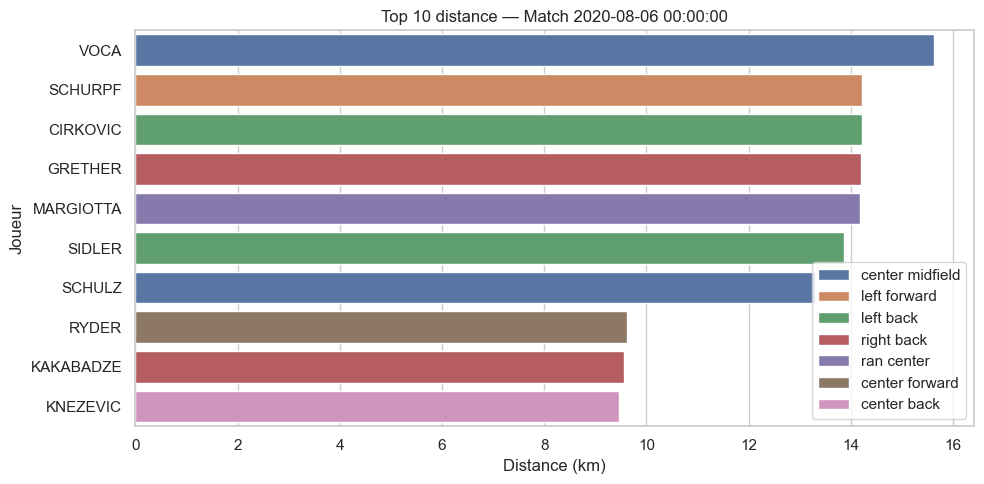

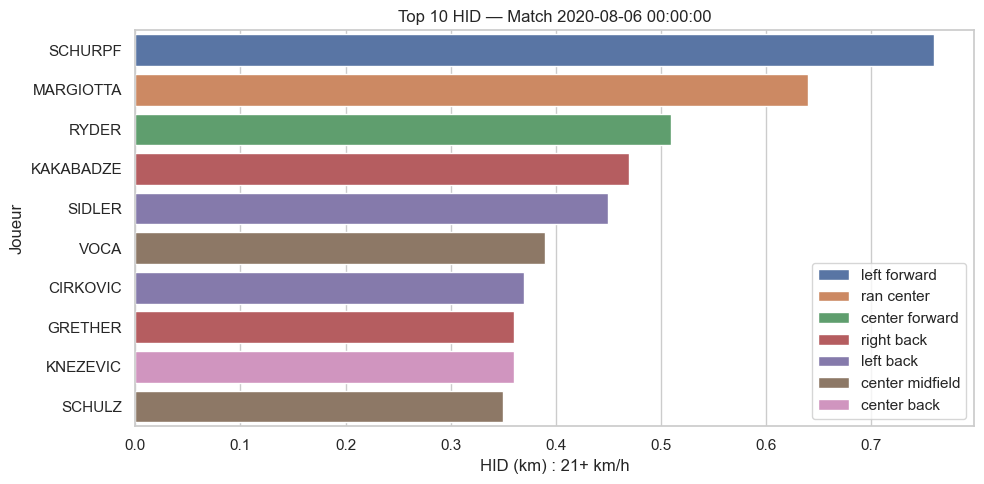

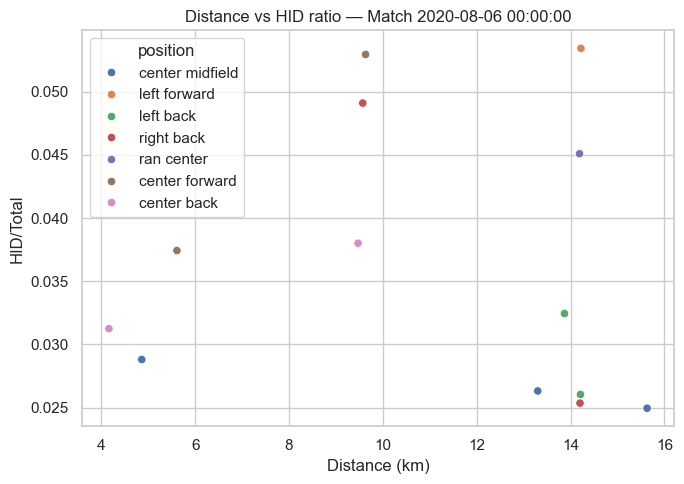

In [11]:
# ---------------------------
# 2) MATCH — SÉANCE SPÉCIFIQUE (auto) (données nettoyées)
# ---------------------------

# Choix auto : match avec distance équipe max (sur données clean)
best_game = con.execute("""
WITH per_match AS (
  SELECT
    date_trunc('day', session_ts)::DATE AS session_date,
    COUNT(DISTINCT sensor) AS n_players,
    SUM(distance_km) AS team_distance_km,
    SUM(coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) AS team_hid_km
  FROM summary_clean
  WHERE session_type='game'
  GROUP BY 1
)
SELECT
  session_date,
  n_players,
  team_distance_km,
  team_hid_km,
  team_hid_km / NULLIF(team_distance_km, 0) AS team_hid_ratio
FROM per_match
ORDER BY team_distance_km DESC NULLS LAST
LIMIT 1;
""").fetchdf()

display(best_game)

game_date = best_game.loc[0, "session_date"]
print("Match choisi:", game_date)

# Table joueurs sur ce match
game_players = con.execute("""
WITH s AS (
  SELECT
    date_trunc('day', session_ts)::DATE AS session_date,
    sensor,
    position,
    distance_km,
    max_speed_kmh,
    coalesce(acc_3mss, 0) AS acc_3mss,
    coalesce(dec_3mss, 0) AS dec_3mss,
    (coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) AS hid_km,
    CASE
      WHEN distance_km IS NULL OR distance_km <= 0 THEN NULL
      ELSE (coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) / distance_km
    END AS hid_ratio
  FROM summary_clean
  WHERE session_type='game'
)
SELECT
  s.session_date,
  s.sensor,
  p.last_name,
  p.first_name,
  s.position,
  s.distance_km,
  s.hid_km,
  s.hid_ratio,
  s.max_speed_kmh,
  s.acc_3mss,
  s.dec_3mss
FROM s
LEFT JOIN players p USING(sensor)
WHERE s.session_date = ?
ORDER BY s.distance_km DESC NULLS LAST;
""", [game_date]).fetchdf()

display(game_players.head(15))

print("Nb joueurs (lignes):", len(game_players))
print("Nb capteurs uniques:", game_players["sensor"].nunique())
print("Distance équipe (km):", np.nan_to_num(game_players["distance_km"]).sum())
print("HID équipe (km):", np.nan_to_num(game_players["hid_km"]).sum())

# Top joueurs
top10_distance = game_players.sort_values("distance_km", ascending=False).head(10)
top10_hid = game_players.sort_values("hid_km", ascending=False).head(10)

display(top10_distance[["sensor","last_name","first_name","position","distance_km","hid_km","max_speed_kmh"]])
display(top10_hid[["sensor","last_name","first_name","position","hid_km","distance_km","max_speed_kmh"]])

# Résumé par poste
by_position = (
    game_players
    .groupby("position", dropna=False)
    .agg(
        n_players=("sensor", "nunique"),
        avg_distance_km=("distance_km", "mean"),
        sum_distance_km=("distance_km", "sum"),
        avg_hid_ratio=("hid_ratio", "mean"),
        avg_max_speed=("max_speed_kmh", "mean"),
    )
    .sort_values("sum_distance_km", ascending=False)
    .reset_index()
)
display(by_position)

# Graphes
plt.figure(figsize=(10, 5))
sns.barplot(data=top10_distance, y="last_name", x="distance_km", hue="position", dodge=False)
plt.title(f"Top 10 distance — Match {game_date}")
plt.xlabel("Distance (km)")
plt.ylabel("Joueur")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top10_hid, y="last_name", x="hid_km", hue="position", dodge=False)
plt.title(f"Top 10 HID — Match {game_date}")
plt.xlabel("HID (km) : 21+ km/h")
plt.ylabel("Joueur")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=game_players, x="distance_km", y="hid_ratio", hue="position")
plt.title(f"Distance vs HID ratio — Match {game_date}")
plt.xlabel("Distance (km)")
plt.ylabel("HID/Total")
plt.tight_layout()
plt.show()

## 3) Entraînements — global équipe (practice global) 

### Objectif
Cette partie sert à **quantifier la charge externe d’entraînement** et sa **variabilité**, puis à **la situer par rapport aux exigences du match** :
- **Volume** : combien l’équipe court (km).
- **Intensité** : quelle part est réalisée à haute vitesse (HID, ≥ 21 km/h).
- **Densité d’efforts** : accélérations/décélérations intenses (≥ 3 m/s²).
- **Exposition à la vitesse** : vitesses max atteintes (moyenne vs pic).
- **Benchmark match** : est-ce que l’entraînement (moyen / séances “dures”) se rapproche du match ?
- **Stabilité** : la charge est-elle régulière ou très fluctuante (semaine / mois) ?

---

## Données utilisées (ce que le code prend exactement)

### Entraînements
Le code part de la vue nettoyée `summary_clean` et garde :
- `session_type = 'practice'`
- `distance_km` non nulle et **≥ 0.1 km** (`PRACTICE_MIN_DISTANCE_KM = 0.1`)  
  → on retire les lignes “quasi zéro” (bruit / joueur très peu exposé).
- `max_speed_kmh` **≤ 40 km/h** (ou `NULL`) (`MAX_SPEED_KMH = 40.0`)  
  → filtre anti-valeurs aberrantes capteurs.

Pour éviter que des valeurs manquantes cassent les sommes équipe, le code remplace par 0 (`coalesce(...,0)`) :
- `acc_3mss`, `dec_3mss`
- distances par zones `d_0_5_km` … `d_over30_km`

### Matchs (pour la comparaison)
Même logique, mais sur :
- `session_type IN ('game','match')`
- `distance_km` non nulle et **≥ 0.5 km** par défaut (`GAME_MIN_DISTANCE_KM`, récupère `MIN_MATCH_DISTANCE_KM` s’il existe)
- `max_speed_kmh` **≤ 40 km/h** (même plafond que l’entraînement)

---

## KPI calculés (définitions + sens terrain)

### 1) Volume
- Joueur : `distance_km`
- Équipe / séance : `team_distance_km = somme(distance_km)`

Lecture club :
- indicateur “macro” du volume de séance,
- **dépend de l’effectif** (si plus de joueurs, la somme équipe augmente).

### 2) Intensité : HID (≥ 21 km/h)
Définition utilisée :
- `hid_km = d_21_24_km + d_24_30_km + d_over30_km`
- `hid_ratio = hid_km / distance_km` (si distance > 0)
- Équipe :
  - `team_hid_km = somme(hid_km)`
  - `team_hid_ratio = team_hid_km / team_distance_km`

Lecture club :
- `team_hid_ratio` = **part de course rapide** dans la séance (contenu intensité),
- ratio pondéré par le volume total.

### 3) Densité d’efforts : accélérations / décélérations intenses
- `team_acc_3mss = somme(acc_3mss)`
- `team_dec_3mss = somme(dec_3mss)`

Lecture club :
- reflète une charge “changement de rythme / neuromusculaire” (utile pour différencier volume vs densité).

### 4) Exposition à la vitesse
- `avg_player_max_speed_kmh` : moyenne des vmax individuelles (exposition globale)
- `max_player_max_speed_kmh` : vmax la plus haute du jour (exposition pic)

### 5) Contenu de séance : zones de vitesse
- Sommes équipe : `team_d_0_5_km` … `team_d_over30_km`

Lecture club :
- montre **comment** le volume est construit (dominante basse vitesse vs présence de haute vitesse).

---

## Agrégation par séance (ce que représente `practice_team_by_day`)
Le code regroupe par `session_date` et calcule :
- `n_players` : nombre de joueurs (capteurs) présents
- `team_*` : **sommes équipe** (sauf vitesses : moyenne et maximum)

Point staff important :
- si `n_players` varie, les KPI “team_*” varient aussi, même si la séance est identique.

---

## Visualisations “practice global” (comment lire les graphes)

### A) Séries temporelles (4 graphiques)
1) Distance totale équipe → volume
2) Part HID (%) → intensité relative
3) Acc/Dec équipe → densité d’efforts
4) Vitesse max (moyenne vs pic) → exposition vitesse

Règles de lecture rapides :
- Distance ↑ mais HID% ↓ : séance plutôt “volume”
- Distance stable mais acc/dec ↑ : séance plus “dense” (jeux réduits, transitions…)
- Pic de vitesse ↑ sans hausse HID : exposition ponctuelle (quelques sprints), pas forcément gros volume rapide

### B) Zones de vitesse (barres empilées)
- Si beaucoup de séances, agrégation **par mois** (plus lisible), sinon **par séance**.

### C) Boxplots par poste (joueurs)
- `distance_km`, `hid_ratio`, `max_speed_kmh` par poste  
→ cohérence des rôles + détection d’extrêmes/variabilité.

---

# 3D) Comparaison entraînement vs match + variabilité (club)

## Pourquoi ajouter des KPI “par joueur” (neutraliser l’effectif)
Pour comparer des séances avec effectifs différents, le code calcule :
- `distance_pp_km = team_distance_km / n_players`
- `hid_pp_km = team_hid_km / n_players`
- `acc_pp = team_acc_3mss / n_players`
- `dec_pp = team_dec_3mss / n_players`

Lecture club :
- ce sont les KPI les plus robustes pour comparer **entraînement vs match** au niveau global.

## Comparaison training vs match : moyennes + percentiles
Le code met entraînements et matchs dans une table commune puis calcule, pour chaque KPI :
- `mean` (moyenne), `p25`, `median`, `p75`, `p90`, et `n_sessions`

Pourquoi les percentiles :
- `p90` décrit les séances “top 10%” → utile pour vérifier si vos séances les plus dures approchent le match.

Visualisations associées (boxplots) :
- `distance_pp_km` : km / joueur / séance (training vs match)
- `hid_pp_km` : km HID / joueur / séance (training vs match)

## Variabilité / stabilité : par semaine et par mois (entraînements)
Le code mesure la régularité de la planification sur les séances d’entraînement :
- Agrégation **hebdomadaire** (`week = W-MON`) :
  - `weekly_distance_km` (volume hebdo)
  - variabilité intra-semaine via un **CV** (coefficient de variation) :
    - $CV = \sigma / \mu$ sur `team_distance_km`, `team_hid_ratio`, `team_acc_3mss`
- Agrégation **mensuelle** (`month`) :
  - `monthly_distance_km`
  - CV sur `team_distance_km` et `team_hid_ratio`

Lecture club :
- **CV faible** → semaines/mois homogènes (séances proches)
- **CV élevé** → planification plus contrastée (récup + séances très dures, variation forte)

---

## Points d’attention (pour éviter les mauvaises conclusions)
- Les KPI `team_*` sont des **sommes** : sensibles à l’effectif (`n_players`).
- Pour comparer training vs match, privilégier les KPI **par joueur** (`*_pp_*`).
- `coalesce(...,0)` permet de sommer sans erreur ; une valeur manquante est traitée comme 0.
- Le filtre `max_speed_kmh <= 40` protège contre les outliers capteurs ; une donnée mal calibrée peut être exclue.

,session_date,n_players,team_distance_km,team_hid_km,team_acc_3mss,team_dec_3mss,avg_player_max_speed_kmh,max_player_max_speed_kmh,team_d_0_5_km,team_d_5_10_km,team_d_10_15_km,team_d_15_21_km,team_d_21_24_km,team_d_24_30_km,team_d_over30_km,team_hid_ratio
0,2019-07-04,21,104.86,2.84,799.0,418.0,22.124286,26.10,42.72,45.33,7.47,6.52,2.74,0.10,0.00,0.027084
1,2019-07-05,14,82.12,2.01,931.0,623.0,27.242857,30.59,39.11,22.90,11.33,6.77,1.40,0.60,0.01,0.024476
2,2019-07-06,21,200.57,3.51,2162.0,1383.0,24.825714,27.66,72.39,57.87,30.74,36.06,3.16,0.35,0.00,0.017500
3,2019-07-08,21,87.12,0.87,497.0,234.0,24.992857,36.88,43.78,28.50,10.22,3.72,0.55,0.27,0.05,0.009986
4,2019-07-10,19,72.61,0.12,467.0,291.0,16.291053,25.10,20.31,44.31,6.25,1.58,0.11,0.01,0.00,0.001653
5,2019-07-11,19,56.78,0.14,549.0,257.0,19.772632,23.54,29.24,19.73,5.32,2.40,0.14,0.00,0.00,0.002466
6,2019-07-12,4,11.60,2.75,347.0,120.0,24.947500,26.25,3.07,1.29,1.06,3.41,2.57,0.18,0.00,0.237069
7,2019-07-16,13,61.26,0.58,439.0,550.0,25.346923,29.76,26.88,19.38,10.90,3.51,0.40,0.18,0.00,0.009468
8,2019-07-17,20,148.08,2.65,1203.0,1046.0,26.166000,28.23,70.37,45.41,21.77,7.85,1.84,0.81,0.00,0.017896
9,2019-07-18,18,59.31,0.64,234.0,163.0,25.130556,36.73,32.92,18.53,4.65,2.50,0.42,0.21,0.01,0.010791


Nb jours d'entraînement: 184


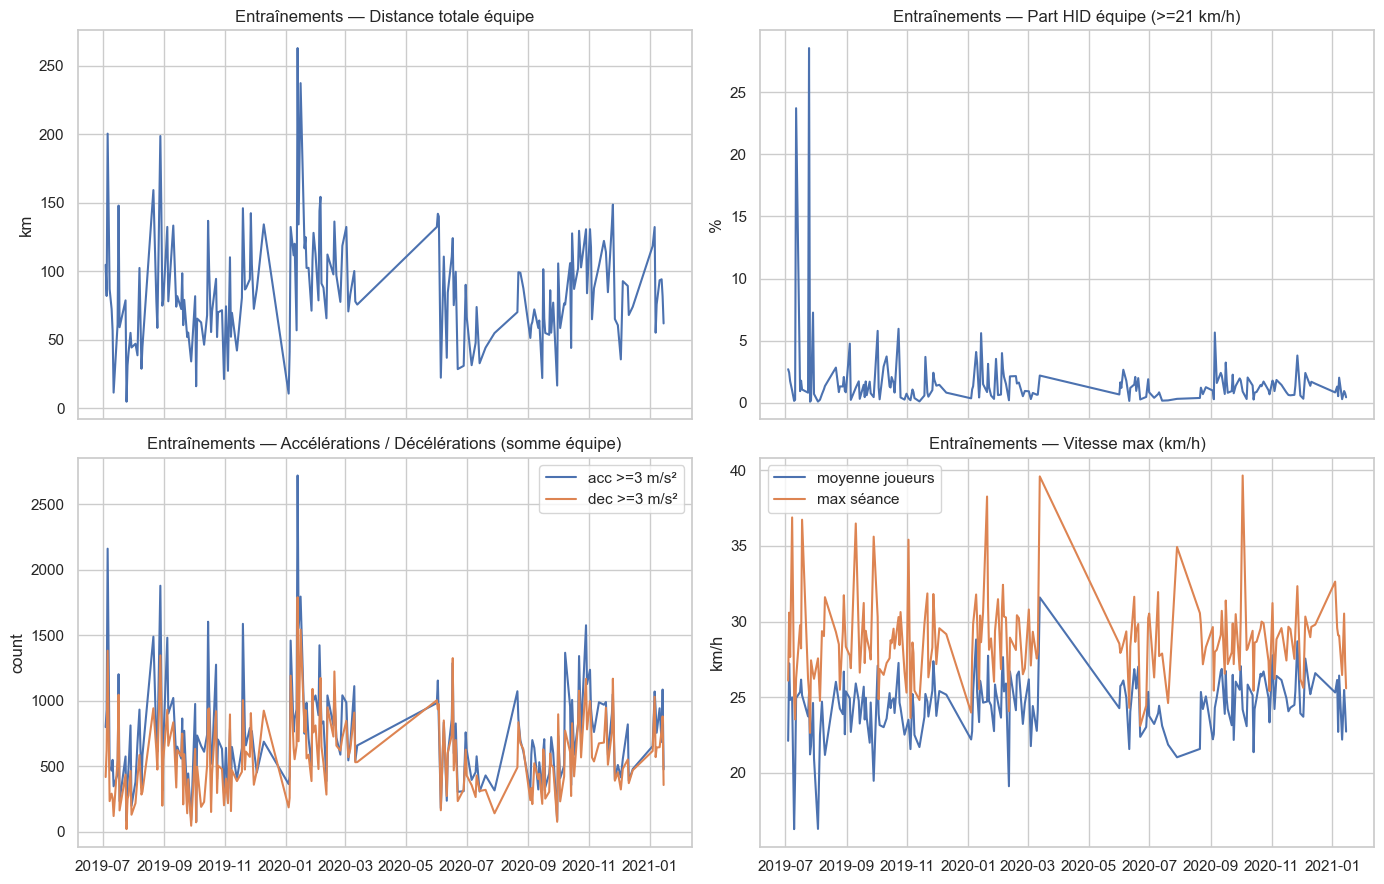

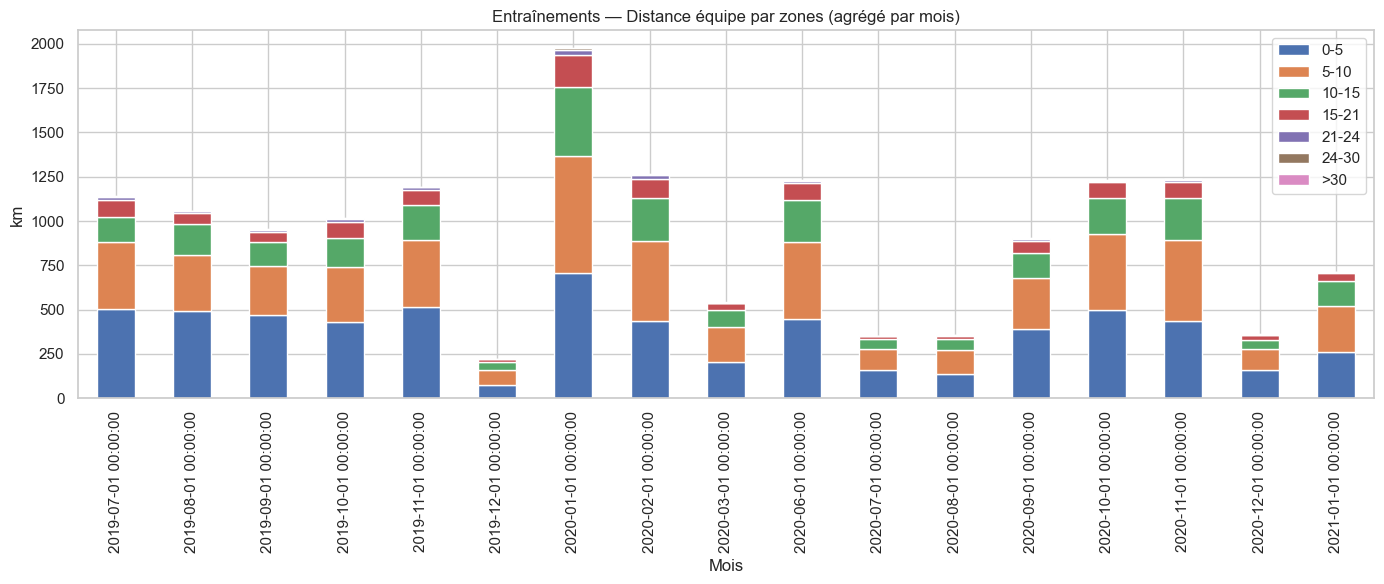

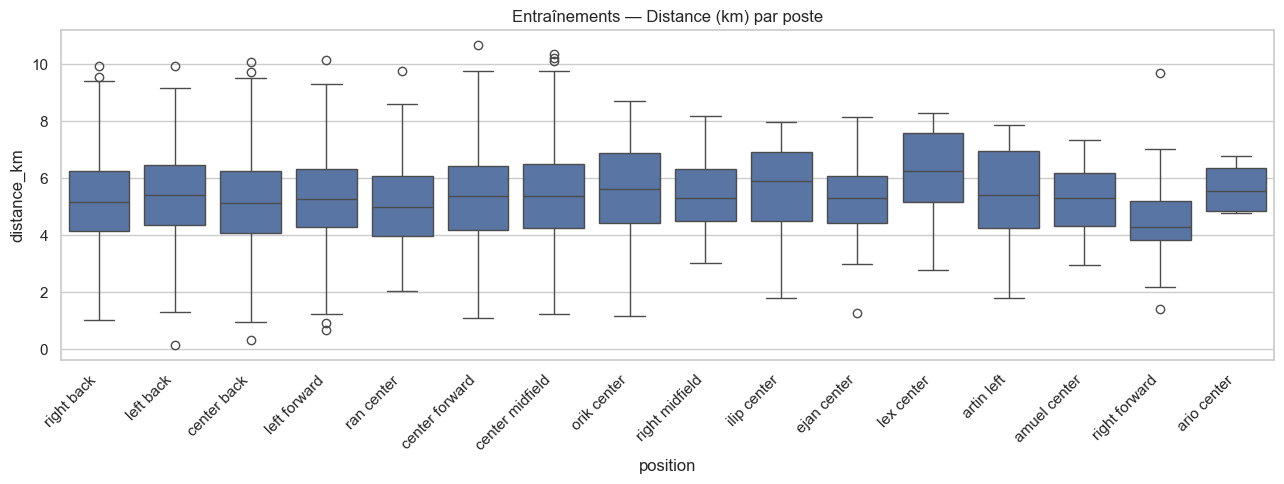

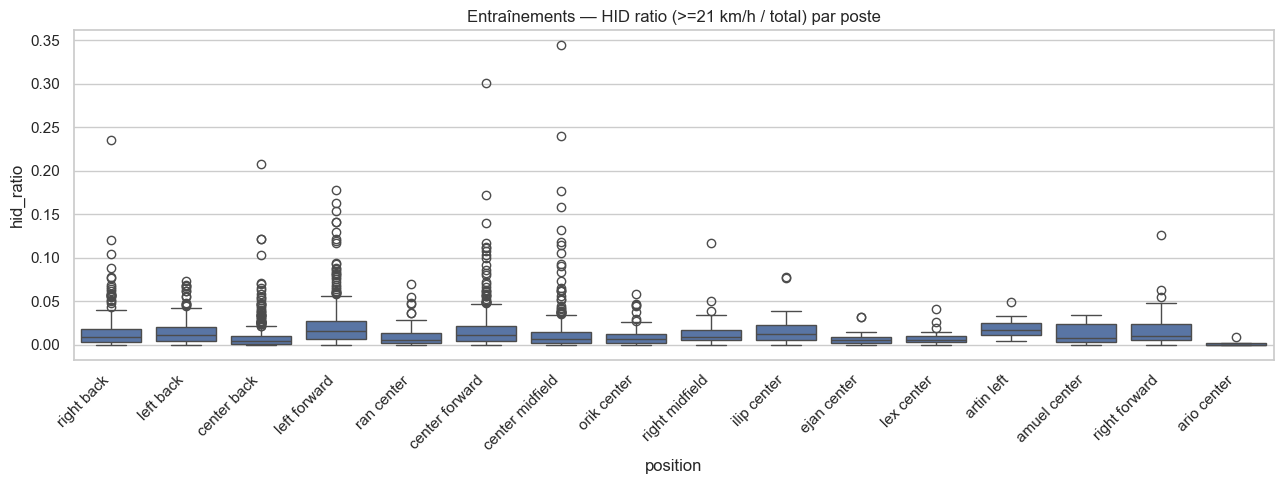

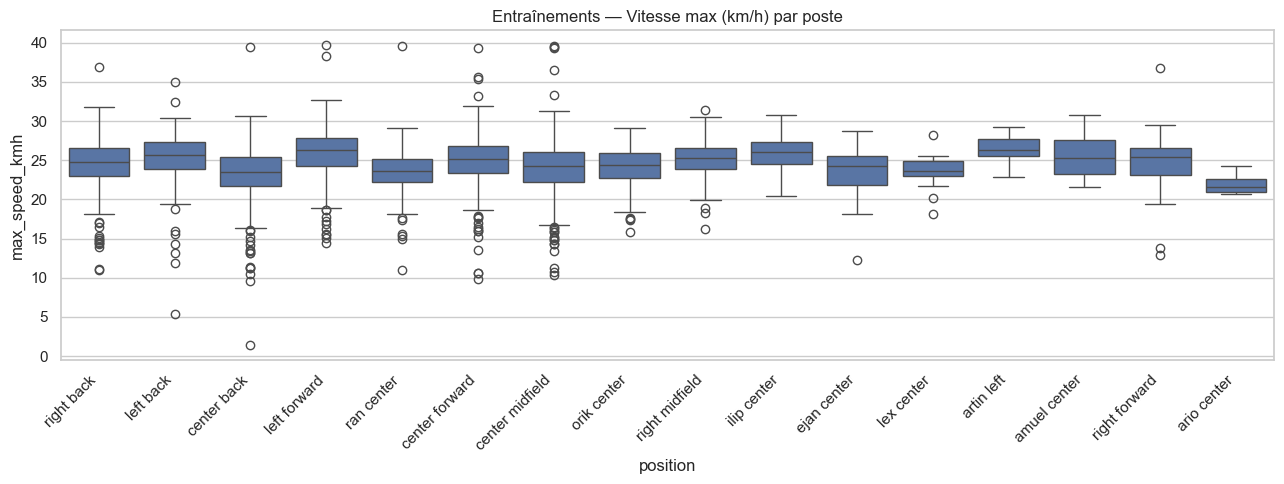

,session_type,metric,mean,p25,median,p75,p90,n_sessions
0,match,acc_pp,58.399844,51.900000,57.692308,65.333333,71.384615,73
10,practice,acc_pp,48.703760,35.128483,44.941176,56.317810,75.071493,184
1,match,avg_player_max_speed_kmh,28.765077,28.306923,28.815714,29.331429,29.657500,73
11,practice,avg_player_max_speed_kmh,24.472341,23.323768,24.656026,25.734761,26.701937,184
2,match,dec_pp,70.933710,62.437500,71.615385,79.153846,87.025641,73
12,practice,dec_pp,37.382179,27.696875,36.222619,46.055556,59.381731,184
3,match,distance_pp_km,8.050458,7.628462,8.296154,8.852500,9.340667,73
13,practice,distance_pp_km,5.431144,4.210735,5.140176,6.421148,7.438364,184
4,match,hid_pp_km,0.314274,0.260769,0.315833,0.366154,0.393795,73
14,practice,hid_pp_km,0.090030,0.030469,0.058452,0.112412,0.191270,184


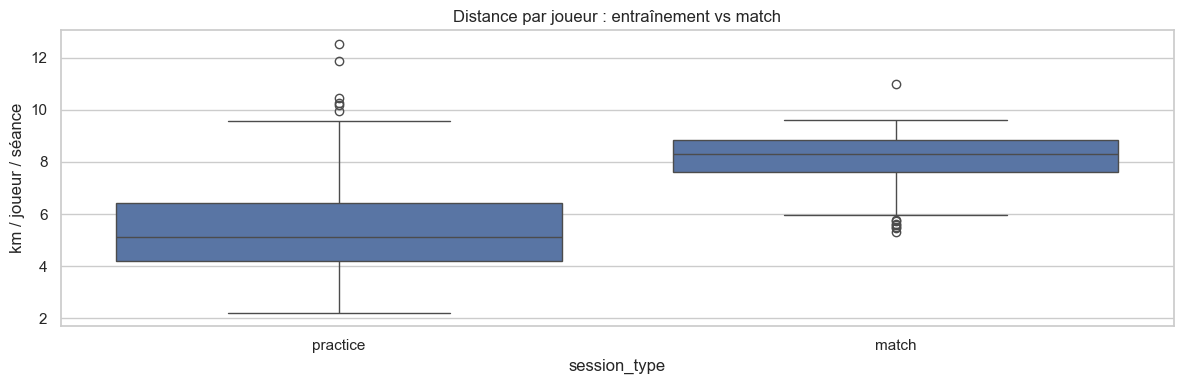

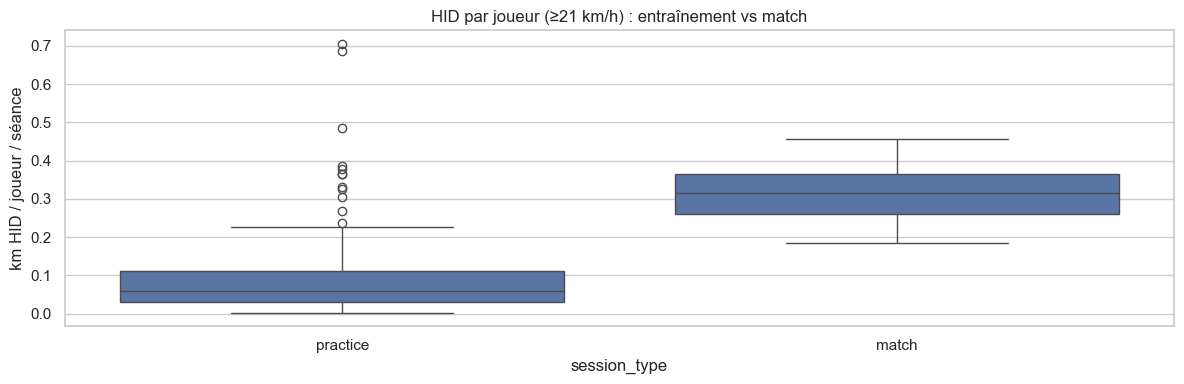

,week,n_sessions,weekly_distance_km,mean_session_distance_km,sd_session_distance_km,mean_session_hid_ratio,sd_session_hid_ratio,mean_session_acc,sd_session_acc,cv_session_distance,cv_session_hid_ratio,cv_session_acc
0,2019-07-02,4,474.67,118.667500,55.466600,0.019762,0.007671,1097.250000,732.708389,0.467412,0.388157,0.667768
1,2019-07-09,3,140.99,46.996667,31.659757,0.080396,0.135684,454.333333,101.593963,0.673660,1.687696,0.223611
2,2019-07-16,3,268.65,89.550000,50.697843,0.012718,0.004532,625.333333,510.666558,0.566140,0.356380,0.816631
3,2019-07-23,5,210.84,42.168000,27.500218,0.073851,0.122014,464.600000,268.835080,0.652158,1.652161,0.578638
4,2019-07-30,3,130.57,43.523333,4.302468,0.003608,0.003192,418.666667,241.711260,0.098854,0.884818,0.577336
...,...,...,...,...,...,...,...,...,...,...,...,...
59,2020-12-08,2,157.65,78.825000,15.011877,0.015379,0.002301,604.000000,305.470129,0.190446,0.149615,0.505745
60,2020-12-15,1,74.25,74.250000,NaN,0.015488,NaN,479.000000,NaN,NaN,NaN,NaN
61,2020-12-29,1,118.57,118.570000,NaN,0.008434,NaN,654.000000,NaN,NaN,NaN,NaN
62,2021-01-05,4,357.19,89.297500,32.720791,0.010462,0.007853,925.750000,129.438209,0.366424,0.750584,0.139820


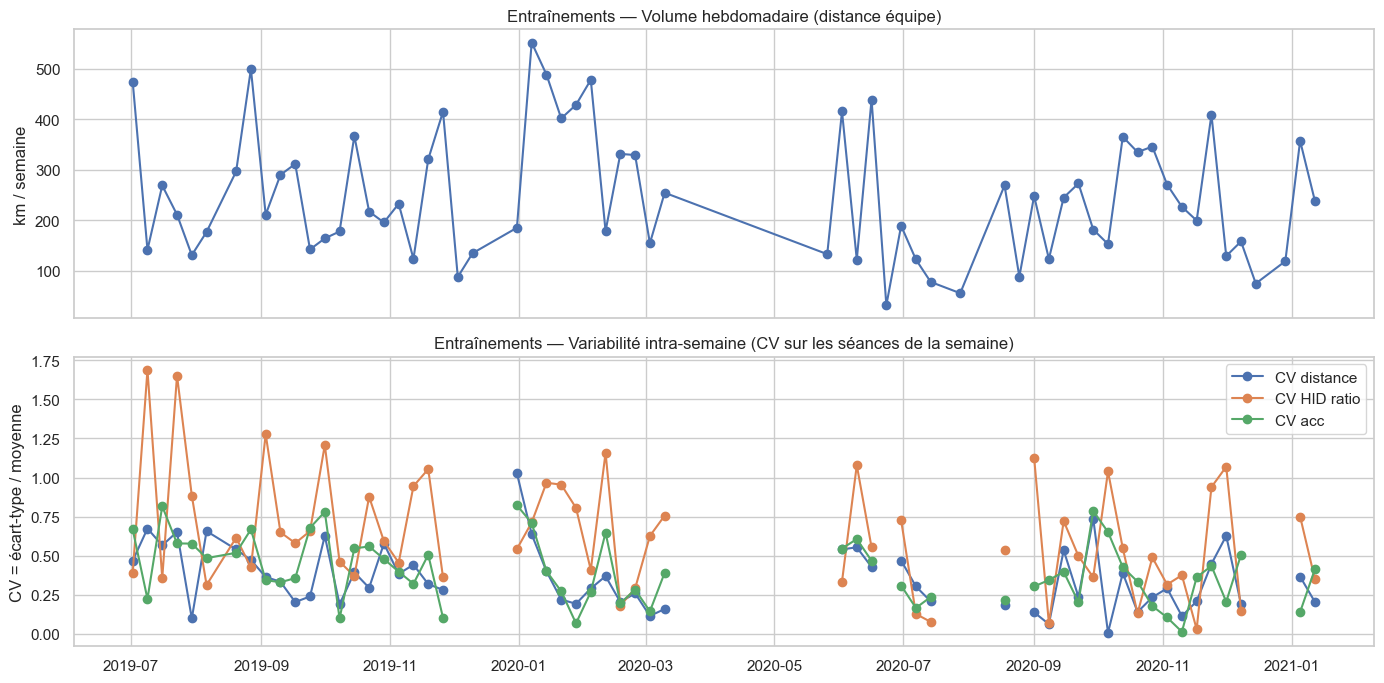

,month,n_sessions,monthly_distance_km,mean_session_distance_km,sd_session_distance_km,mean_session_hid_ratio,sd_session_hid_ratio,cv_session_distance,cv_session_hid_ratio
0,2019-07-01,16,1139.67,71.229375,49.062016,0.045927,0.086255,0.688789,1.878083
1,2019-08-01,12,1058.66,88.221667,53.561064,0.011498,0.007467,0.607119,0.649380
2,2019-09-01,12,953.77,79.480833,29.989425,0.012932,0.012357,0.377316,0.955513
3,2019-10-01,15,1018.28,67.885333,30.062496,0.021024,0.018523,0.442842,0.881044
4,2019-11-01,14,1193.27,85.233571,33.862447,0.010989,0.009895,0.397290,0.900463
5,2019-12-01,2,221.63,110.815000,33.283516,0.011406,0.004447,0.300352,0.389859
6,2020-01-01,17,1976.93,116.290000,61.097893,0.018565,0.015342,0.525392,0.826402
7,2020-02-01,12,1263.03,105.252500,28.217230,0.016898,0.010539,0.268091,0.623673
8,2020-03-01,6,540.95,90.158333,23.079149,0.009293,0.006574,0.255985,0.707411
9,2020-06-01,14,1230.20,87.871429,42.907642,0.013257,0.007471,0.488300,0.563529


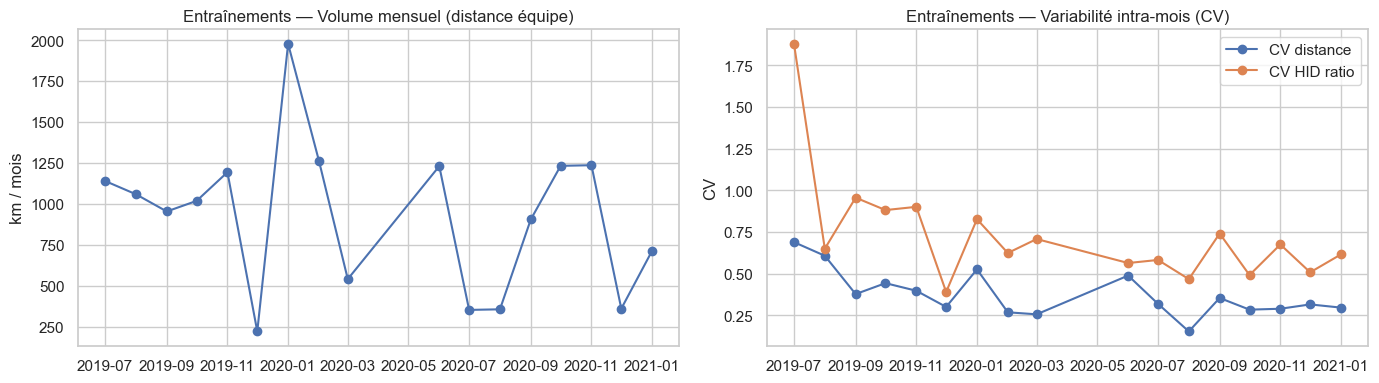

In [12]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 3) ENTRAÎNEMENTS — GLOBAL ÉQUIPE (practice global)
# + 3D) TRAINING vs MATCH + VARIABILITÉ (club)
# ---------------------------

# Paramètres cohérents (utilisés partout)
PRACTICE_MIN_DISTANCE_KM = 0.1
MAX_SPEED_KMH = 40.0

# Pour les matchs : on réutilise le même plafond de vitesse
GAME_MIN_DISTANCE_KM = float(globals().get("MIN_MATCH_DISTANCE_KM", 0.5))
GAME_MAX_SPEED_KMH = MAX_SPEED_KMH

# ---------------------------
# A) Extraction + KPI joueurs (practice)
# ---------------------------
practice_players = con.execute("""
SELECT
  date_trunc('day', session_ts)::DATE AS session_date,
  sensor,
  position,
  distance_km,
  max_speed_kmh,
  coalesce(acc_3mss, 0) AS acc_3mss,
  coalesce(dec_3mss, 0) AS dec_3mss,

  coalesce(d_0_5_km, 0) AS d_0_5_km,
  coalesce(d_5_10_km, 0) AS d_5_10_km,
  coalesce(d_10_15_km, 0) AS d_10_15_km,
  coalesce(d_15_21_km, 0) AS d_15_21_km,
  coalesce(d_21_24_km, 0) AS d_21_24_km,
  coalesce(d_24_30_km, 0) AS d_24_30_km,
  coalesce(d_over30_km, 0) AS d_over30_km
FROM summary_clean
WHERE session_type = 'practice'
  AND distance_km IS NOT NULL
  AND distance_km >= ?
  AND (max_speed_kmh IS NULL OR max_speed_kmh <= ?);
""", [PRACTICE_MIN_DISTANCE_KM, MAX_SPEED_KMH]).fetchdf()

practice_players["hid_km"] = (
    practice_players["d_21_24_km"] + practice_players["d_24_30_km"] + practice_players["d_over30_km"]
)
practice_players["hid_ratio"] = np.where(
    practice_players["distance_km"] > 0,
    practice_players["hid_km"] / practice_players["distance_km"],
    np.nan
)

# ---------------------------
# B) Agrégation équipe / séance (practice)
# ---------------------------
practice_team_by_day = (
    practice_players
    .groupby("session_date", as_index=False)
    .agg(
        n_players=("sensor", "nunique"),
        team_distance_km=("distance_km", "sum"),
        team_hid_km=("hid_km", "sum"),
        team_acc_3mss=("acc_3mss", "sum"),
        team_dec_3mss=("dec_3mss", "sum"),
        avg_player_max_speed_kmh=("max_speed_kmh", "mean"),
        max_player_max_speed_kmh=("max_speed_kmh", "max"),

        team_d_0_5_km=("d_0_5_km", "sum"),
        team_d_5_10_km=("d_5_10_km", "sum"),
        team_d_10_15_km=("d_10_15_km", "sum"),
        team_d_15_21_km=("d_15_21_km", "sum"),
        team_d_21_24_km=("d_21_24_km", "sum"),
        team_d_24_30_km=("d_24_30_km", "sum"),
        team_d_over30_km=("d_over30_km", "sum"),
    )
    .sort_values("session_date")
)

practice_team_by_day["team_hid_ratio"] = (
    practice_team_by_day["team_hid_km"] /
    practice_team_by_day["team_distance_km"].replace({0: np.nan})
)
practice_team_by_day["session_date"] = pd.to_datetime(practice_team_by_day["session_date"])

display(practice_team_by_day.head(10))
print("Nb jours d'entraînement:", practice_team_by_day["session_date"].nunique())

# ---------------------------
# C) Graphes practice (global)
# ---------------------------

# C1) Séries temporelles
fig, ax = plt.subplots(2, 2, figsize=(14, 9), sharex=True)

ax[0, 0].plot(practice_team_by_day["session_date"], practice_team_by_day["team_distance_km"])
ax[0, 0].set_title("Entraînements — Distance totale équipe")
ax[0, 0].set_ylabel("km")

ax[0, 1].plot(practice_team_by_day["session_date"], 100 * practice_team_by_day["team_hid_ratio"])
ax[0, 1].set_title("Entraînements — Part HID équipe (>=21 km/h)")
ax[0, 1].set_ylabel("%")

ax[1, 0].plot(practice_team_by_day["session_date"], practice_team_by_day["team_acc_3mss"], label="acc >=3 m/s²")
ax[1, 0].plot(practice_team_by_day["session_date"], practice_team_by_day["team_dec_3mss"], label="dec >=3 m/s²")
ax[1, 0].set_title("Entraînements — Accélérations / Décélérations (somme équipe)")
ax[1, 0].set_ylabel("count")
ax[1, 0].legend()

ax[1, 1].plot(practice_team_by_day["session_date"], practice_team_by_day["avg_player_max_speed_kmh"], label="moyenne joueurs")
ax[1, 1].plot(practice_team_by_day["session_date"], practice_team_by_day["max_player_max_speed_kmh"], label="max séance")
ax[1, 1].set_title("Entraînements — Vitesse max (km/h)")
ax[1, 1].set_ylabel("km/h")
ax[1, 1].legend()

plt.tight_layout()
plt.show()

# C2) Zones de vitesse (agrégé par mois si beaucoup de séances)
zones_cols = [
    "team_d_0_5_km", "team_d_5_10_km", "team_d_10_15_km",
    "team_d_15_21_km", "team_d_21_24_km", "team_d_24_30_km", "team_d_over30_km"
]
zones_labels = ["0-5", "5-10", "10-15", "15-21", "21-24", "24-30", ">30"]

zones = practice_team_by_day[["session_date"] + zones_cols].copy()
zones = zones.rename(columns=dict(zip(zones_cols, zones_labels)))

if len(zones) > 25:
    zones["month"] = zones["session_date"].dt.to_period("M").dt.to_timestamp()
    zones_plot = zones.groupby("month")[zones_labels].sum()
    xlab = "Mois"
    title = "Entraînements — Distance équipe par zones (agrégé par mois)"
else:
    zones_plot = zones.set_index("session_date")[zones_labels]
    xlab = "Séance"
    title = "Entraînements — Distance équipe par zones (par séance)"

ax = zones_plot.plot(kind="bar", stacked=True, figsize=(14, 6))
ax.set_title(title)
ax.set_xlabel(xlab)
ax.set_ylabel("km")
plt.tight_layout()
plt.show()

# C3) Dispersion par poste (joueurs)
plt.figure(figsize=(13, 5))
sns.boxplot(data=practice_players, x="position", y="distance_km")
plt.xticks(rotation=45, ha="right")
plt.title("Entraînements — Distance (km) par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=practice_players, x="position", y="hid_ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Entraînements — HID ratio (>=21 km/h / total) par poste")
plt.tight_layout()
plt.show()

plt.figure(figsize=(13, 5))
sns.boxplot(data=practice_players, x="position", y="max_speed_kmh")
plt.xticks(rotation=45, ha="right")
plt.title("Entraînements — Vitesse max (km/h) par poste")
plt.tight_layout()
plt.show()

# ---------------------------
# 3D) TRAINING vs MATCH + VARIABILITÉ (club)
# ---------------------------

# D1) KPI "par joueur" (neutraliser l'effet effectif)
practice_team_by_day = practice_team_by_day.copy()
practice_team_by_day["distance_pp_km"] = practice_team_by_day["team_distance_km"] / practice_team_by_day["n_players"].replace({0: np.nan})
practice_team_by_day["hid_pp_km"] = practice_team_by_day["team_hid_km"] / practice_team_by_day["n_players"].replace({0: np.nan})
practice_team_by_day["acc_pp"] = practice_team_by_day["team_acc_3mss"] / practice_team_by_day["n_players"].replace({0: np.nan})
practice_team_by_day["dec_pp"] = practice_team_by_day["team_dec_3mss"] / practice_team_by_day["n_players"].replace({0: np.nan})

# D2) Construire l'équivalent match (mêmes KPI)
game_players_cmp = con.execute("""
SELECT
  date_trunc('day', session_ts)::DATE AS session_date,
  sensor,
  position,
  distance_km,
  max_speed_kmh,
  coalesce(acc_3mss, 0) AS acc_3mss,
  coalesce(dec_3mss, 0) AS dec_3mss,
  coalesce(d_21_24_km, 0) AS d_21_24_km,
  coalesce(d_24_30_km, 0) AS d_24_30_km,
  coalesce(d_over30_km, 0) AS d_over30_km
FROM summary_clean
WHERE session_type IN ('game', 'match')
  AND distance_km IS NOT NULL
  AND distance_km >= ?
  AND (max_speed_kmh IS NULL OR max_speed_kmh <= ?);
""", [GAME_MIN_DISTANCE_KM, GAME_MAX_SPEED_KMH]).fetchdf()

if len(game_players_cmp) == 0:
    print("Aucun match trouvé dans summary_clean avec session_type IN ('game','match').")
else:
    game_players_cmp["hid_km"] = (
        game_players_cmp["d_21_24_km"] + game_players_cmp["d_24_30_km"] + game_players_cmp["d_over30_km"]
    )

    game_team_by_day_cmp = (
        game_players_cmp
        .groupby("session_date", as_index=False)
        .agg(
            n_players=("sensor", "nunique"),
            team_distance_km=("distance_km", "sum"),
            team_hid_km=("hid_km", "sum"),
            team_acc_3mss=("acc_3mss", "sum"),
            team_dec_3mss=("dec_3mss", "sum"),
            avg_player_max_speed_kmh=("max_speed_kmh", "mean"),
            max_player_max_speed_kmh=("max_speed_kmh", "max"),
        )
    )
    game_team_by_day_cmp["session_date"] = pd.to_datetime(game_team_by_day_cmp["session_date"])
    game_team_by_day_cmp["team_hid_ratio"] = (
        game_team_by_day_cmp["team_hid_km"] /
        game_team_by_day_cmp["team_distance_km"].replace({0: np.nan})
    )
    game_team_by_day_cmp["distance_pp_km"] = game_team_by_day_cmp["team_distance_km"] / game_team_by_day_cmp["n_players"].replace({0: np.nan})
    game_team_by_day_cmp["hid_pp_km"] = game_team_by_day_cmp["team_hid_km"] / game_team_by_day_cmp["n_players"].replace({0: np.nan})
    game_team_by_day_cmp["acc_pp"] = game_team_by_day_cmp["team_acc_3mss"] / game_team_by_day_cmp["n_players"].replace({0: np.nan})
    game_team_by_day_cmp["dec_pp"] = game_team_by_day_cmp["team_dec_3mss"] / game_team_by_day_cmp["n_players"].replace({0: np.nan})

    # D3) Stats training vs match : moyennes + percentiles
    cols_compare = [
        "team_distance_km", "team_hid_ratio", "team_acc_3mss", "team_dec_3mss",
        "avg_player_max_speed_kmh", "max_player_max_speed_kmh",
        "distance_pp_km", "hid_pp_km", "acc_pp", "dec_pp"
    ]

    comp_pr = practice_team_by_day[["session_date"] + cols_compare].copy()
    comp_pr["session_type"] = "practice"
    comp_ga = game_team_by_day_cmp[["session_date"] + cols_compare].copy()
    comp_ga["session_type"] = "match"

    comp = pd.concat([comp_pr, comp_ga], ignore_index=True)

    def summarize_series(s: pd.Series) -> dict:
        s = s.dropna()
        if len(s) == 0:
            return {"mean": np.nan, "p25": np.nan, "median": np.nan, "p75": np.nan, "p90": np.nan}
        return {
            "mean": float(s.mean()),
            "p25": float(s.quantile(0.25)),
            "median": float(s.median()),
            "p75": float(s.quantile(0.75)),
            "p90": float(s.quantile(0.90)),
        }

    rows = []
    melted = comp.melt(id_vars=["session_type", "session_date"], value_vars=cols_compare)
    for (t, metric), g in melted.groupby(["session_type", "variable"]):
        stats = summarize_series(g["value"])
        rows.append({"session_type": t, "metric": metric, **stats, "n_sessions": g["session_date"].nunique()})

    comp_stats = pd.DataFrame(rows).sort_values(["metric", "session_type"])
    display(comp_stats)

    # D4) Distributions (focus KPI par joueur)
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=comp, x="session_type", y="distance_pp_km")
    plt.title("Distance par joueur : entraînement vs match")
    plt.ylabel("km / joueur / séance")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    sns.boxplot(data=comp, x="session_type", y="hid_pp_km")
    plt.title("HID par joueur (≥21 km/h) : entraînement vs match")
    plt.ylabel("km HID / joueur / séance")
    plt.tight_layout()
    plt.show()

    # D5) Variabilité / stabilité : semaines et mois (entraînements)
    pr = practice_team_by_day.sort_values("session_date").copy()
    pr["week"] = pr["session_date"].dt.to_period("W-MON").dt.start_time
    pr["month"] = pr["session_date"].dt.to_period("M").dt.to_timestamp()

    weekly = (
        pr.groupby("week", as_index=False)
        .agg(
            n_sessions=("session_date", "nunique"),
            weekly_distance_km=("team_distance_km", "sum"),
            mean_session_distance_km=("team_distance_km", "mean"),
            sd_session_distance_km=("team_distance_km", "std"),
            mean_session_hid_ratio=("team_hid_ratio", "mean"),
            sd_session_hid_ratio=("team_hid_ratio", "std"),
            mean_session_acc=("team_acc_3mss", "mean"),
            sd_session_acc=("team_acc_3mss", "std"),
        )
    )
    weekly["cv_session_distance"] = weekly["sd_session_distance_km"] / weekly["mean_session_distance_km"].replace({0: np.nan})
    weekly["cv_session_hid_ratio"] = weekly["sd_session_hid_ratio"] / weekly["mean_session_hid_ratio"].replace({0: np.nan})
    weekly["cv_session_acc"] = weekly["sd_session_acc"] / weekly["mean_session_acc"].replace({0: np.nan})

    display(weekly.sort_values("week"))

    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    ax[0].plot(weekly["week"], weekly["weekly_distance_km"], marker="o")
    ax[0].set_title("Entraînements — Volume hebdomadaire (distance équipe)")
    ax[0].set_ylabel("km / semaine")

    ax[1].plot(weekly["week"], weekly["cv_session_distance"], marker="o", label="CV distance")
    ax[1].plot(weekly["week"], weekly["cv_session_hid_ratio"], marker="o", label="CV HID ratio")
    ax[1].plot(weekly["week"], weekly["cv_session_acc"], marker="o", label="CV acc")
    ax[1].set_title("Entraînements — Variabilité intra-semaine (CV sur les séances de la semaine)")
    ax[1].set_ylabel("CV = écart-type / moyenne")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    monthly = (
        pr.groupby("month", as_index=False)
        .agg(
            n_sessions=("session_date", "nunique"),
            monthly_distance_km=("team_distance_km", "sum"),
            mean_session_distance_km=("team_distance_km", "mean"),
            sd_session_distance_km=("team_distance_km", "std"),
            mean_session_hid_ratio=("team_hid_ratio", "mean"),
            sd_session_hid_ratio=("team_hid_ratio", "std"),
        )
    )
    monthly["cv_session_distance"] = monthly["sd_session_distance_km"] / monthly["mean_session_distance_km"].replace({0: np.nan})
    monthly["cv_session_hid_ratio"] = monthly["sd_session_hid_ratio"] / monthly["mean_session_hid_ratio"].replace({0: np.nan})

    display(monthly.sort_values("month"))

    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].plot(monthly["month"], monthly["monthly_distance_km"], marker="o")
    ax[0].set_title("Entraînements — Volume mensuel (distance équipe)")
    ax[0].set_ylabel("km / mois")

    ax[1].plot(monthly["month"], monthly["cv_session_distance"], marker="o", label="CV distance")
    ax[1].plot(monthly["month"], monthly["cv_session_hid_ratio"], marker="o", label="CV HID ratio")
    ax[1].set_title("Entraînements — Variabilité intra-mois (CV)")
    ax[1].set_ylabel("CV")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

## 4) Entraînements — séance spécifique (practice spécifique)

### Objectif
Cette section fait un **zoom sur une séance d’entraînement précise** pour passer du “global” à une lecture **opérationnelle** :
- qualifier la séance (plutôt **volume**, plutôt **intensité HID**, plutôt **dense** via acc/dec),
- identifier les joueurs les plus sollicités (volume) et les plus exposés (haute vitesse),
- comparer les profils par poste sur **la même séance**.

---

### 4A) Sélection automatique de la séance analysée (`best_practice`)
Le code choisit automatiquement une séance à analyser : **celle avec la plus grande distance totale équipe**.

**Comment la requête SQL travaille**
1) Elle agrège `summary_clean` **par jour** (CTE `per_sess`) sur les entraînements :
- `session_date` : date de la séance (jour)
- `n_players` : nombre de joueurs présents (`COUNT(DISTINCT sensor)`)
- `team_distance_km` : somme des distances de tous les joueurs
- `team_hid_km` : somme de la distance à haute intensité (≥ 21 km/h) :
  - `d_21_24_km + d_24_30_km + d_over30_km`

2) Elle applique les filtres qualité (cohérents avec le reste du notebook) :
- `session_type='practice'`
- `distance_km` non nulle et `distance_km >= PRACTICE_MIN_DISTANCE_KM`
- `max_speed_kmh <= MAX_SPEED_KMH` (ou `NULL`)

3) Elle calcule ensuite :
- `team_hid_ratio = team_hid_km / team_distance_km`  
  (avec `NULLIF(team_distance_km, 0)` pour éviter une division par zéro)

4) Elle trie et sélectionne :
- `ORDER BY team_distance_km DESC`
- `LIMIT 1`  
→ la séance retenue est donc **la plus “volumineuse”** en distance équipe.

**Interprétation club**
- c’est un choix simple pour illustrer une séance “chargée” en volume.
- ce n’est pas forcément la séance la plus intense (HID ratio) ni la plus “dense” (acc/dec).

---

### 4B) Extraction des joueurs de la séance choisie (`practice_day_players`)
Une fois la date `practice_date` identifiée, le code extrait **tous les joueurs** de ce jour et calcule leurs KPI individuels.

**Ce que calcule le bloc SQL (CTE `s`)**
Pour chaque joueur et pour chaque jour :
- `distance_km`
- `max_speed_kmh`
- `acc_3mss` et `dec_3mss` (avec `coalesce(...,0)` si manquant)
- `hid_km = d_21_24_km + d_24_30_km + d_over30_km`
- `hid_ratio = hid_km / distance_km` uniquement si `distance_km > 0` (sinon `NULL`)

Ensuite :
- `LEFT JOIN players` pour récupérer `last_name` et `first_name` à partir du capteur (`sensor`)
- filtre `WHERE s.session_date = practice_date`
- trie `ORDER BY s.distance_km DESC` (les plus gros volumes en premier)

**Interprétation club**
- c’est la “fiche séance” : qui a pris le plus de volume, qui a pris le plus d’HID, qui a atteint les plus grosses vitesses, etc.

---

### 4C) Graphiques produits (comment les lire)

#### 1) Top 10 distance (barplot)
Le code construit `top10_practice_dist` (les 10 plus grosses distances) puis trace :
- axe X : `distance_km`
- axe Y : `last_name`
- couleur : `position`

**Lecture staff**
- identifie les joueurs les plus sollicités en **volume** sur cette séance,
- utile pour repérer une surcharge potentielle ou une sous-exposition.

#### 2) Top 10 HID (barplot)
Le code construit `top10_practice_hid` (les 10 plus grosses HID) puis trace :
- axe X : `hid_km` (km à ≥ 21 km/h)
- axe Y : `last_name`
- couleur : `position`

**Lecture staff**
- identifie les joueurs les plus exposés à la **haute intensité / haute vitesse**,
- permet de vérifier si certains rôles (couloirs, attaquants, latéraux) reçoivent l’exposition attendue.

#### 3) Distance vs HID ratio (scatter)
Chaque point = 1 joueur sur la séance :
- axe X : `distance_km` (volume)
- axe Y : `hid_ratio` (part de haute intensité)
- couleur : `position`

**Lecture rapide**
- **haut-droite** : gros volume + forte intensité (séance très exigeante pour ce joueur)
- **bas-droite** : gros volume mais intensité relative faible (profil “aérobie / volume”)
- **haut-gauche** : intensité relative forte mais faible volume (exposition rapide courte / séance très spécifique)

---

### Points d’attention (limites)
- Ce zoom est basé sur `summary_clean` (KPI “séance”) : on n’a pas ici de découpage **minute par minute** (“segments temporels” au sens strict). Pour cela, il faudrait exploiter les fichiers de tracking bruts.
- La séance choisie est la plus “volumineuse” (distance équipe). Si l’objectif est de zoomer sur la séance la plus intense, il faudrait sélectionner par `team_hid_ratio` ou `team_hid_km` plutôt que par `team_distance_km`.

,session_date,n_players,team_distance_km,team_hid_km,team_hid_ratio
0,2020-01-13,21,263.01,3.97,0.015094


Entraînement choisi: 2020-01-13 00:00:00


,session_date,sensor,last_name,first_name,position,distance_km,hid_km,hid_ratio,max_speed_kmh,acc_3mss,dec_3mss
0,2020-01-13,12,SIDLER,SYLVAN,left back,7.59,0.11,0.014493,26.00,95.0,54.0
1,2020-01-13,28,TIA,CHEF,center forward,7.58,0.24,0.031662,28.48,94.0,44.0
2,2020-01-13,23,MISTVAFOVIC,DAVID,center back,7.32,0.14,0.019126,26.77,113.0,75.0
3,2020-01-13,19,OWUSU,TYRON,left forward,7.30,0.17,0.023288,28.23,95.0,51.0
4,2020-01-13,14,VOCA,IDRIZ,center midfield,7.24,0.11,0.015193,26.47,72.0,53.0
5,2020-01-13,4,KNEZEVIC,STEFAN,center back,7.16,0.05,0.006983,25.95,71.0,45.0
6,2020-01-13,21,MALES,DARIAN,center forward,7.14,0.09,0.012605,23.95,89.0,37.0
7,2020-01-13,20,DEMHASAJ,MIMI,center forward,7.11,0.10,0.014065,28.44,61.0,46.0
8,2020-01-13,7,IBRAH,NDIAYE,left forward,7.07,0.22,0.031117,26.09,105.0,74.0
9,2020-01-13,18,EMINI,LORIK,orik center,7.04,0.08,0.011364,28.65,67.0,54.0


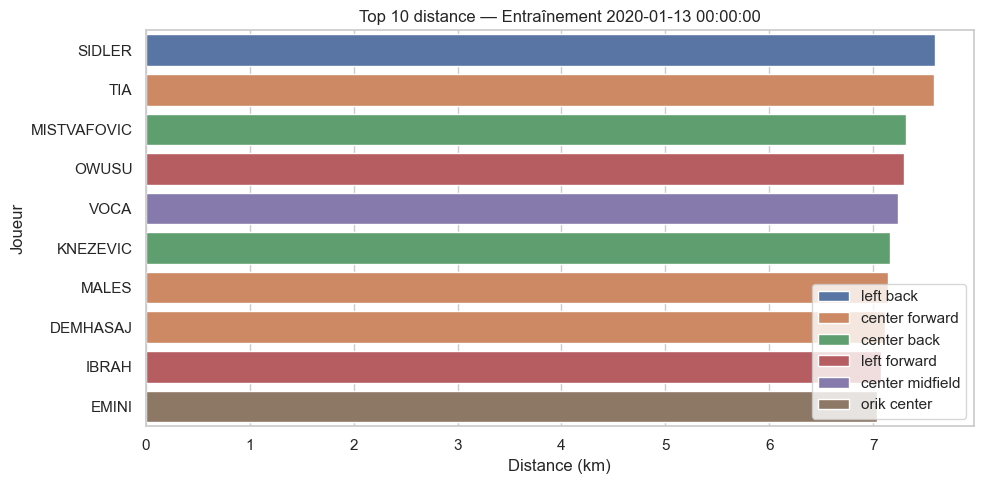

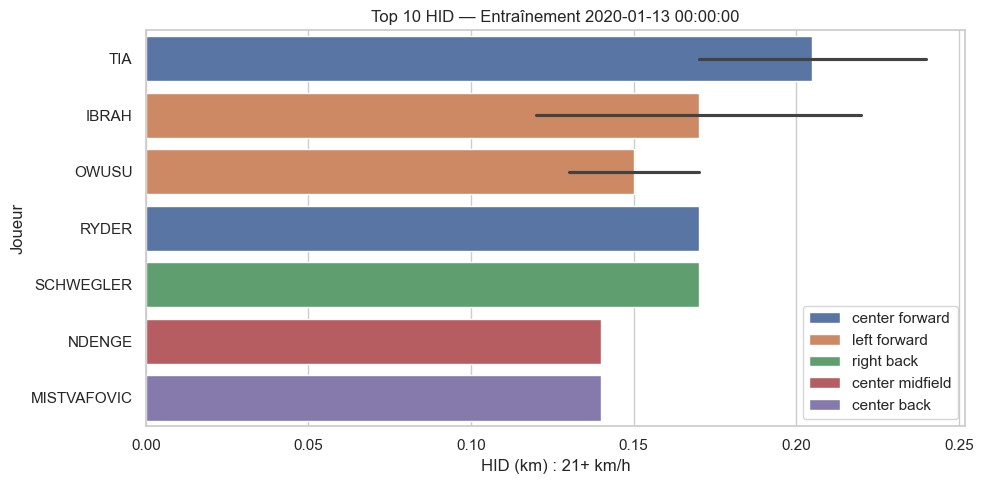

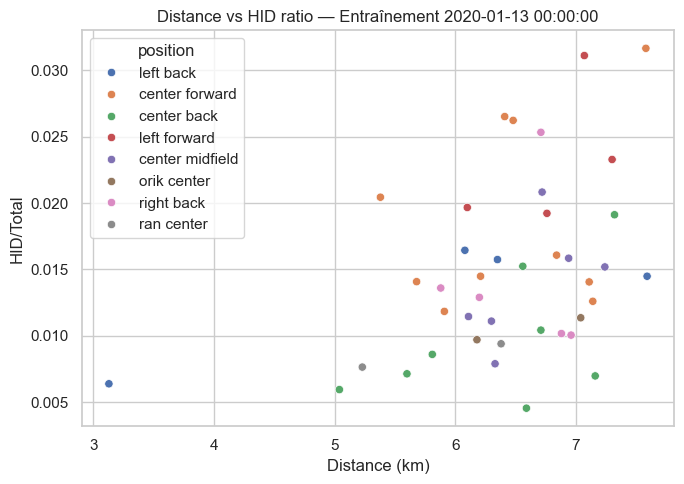

In [13]:
# ---------------------------
# 4) ENTRAÎNEMENT — SÉANCE SPÉCIFIQUE (auto)
# ---------------------------

best_practice = con.execute("""
WITH per_sess AS (
  SELECT
    date_trunc('day', session_ts)::DATE AS session_date,
    COUNT(DISTINCT sensor) AS n_players,
    SUM(distance_km) AS team_distance_km,
    SUM(coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) AS team_hid_km
  FROM summary_clean
WHERE session_type='practice'
  AND distance_km IS NOT NULL
  AND distance_km >= ?
  AND (max_speed_kmh IS NULL OR max_speed_kmh <= ?)
  GROUP BY 1
)
SELECT
  session_date, n_players, team_distance_km, team_hid_km,
  team_hid_km / NULLIF(team_distance_km, 0) AS team_hid_ratio
FROM per_sess
ORDER BY team_distance_km DESC NULLS LAST
LIMIT 1;
""", [PRACTICE_MIN_DISTANCE_KM, MAX_SPEED_KMH]).fetchdf()

display(best_practice)

practice_date = best_practice.loc[0, "session_date"]
print("Entraînement choisi:", practice_date)

practice_day_players = con.execute("""
WITH s AS (
  SELECT
    date_trunc('day', session_ts)::DATE AS session_date,
    sensor,
    position,
    distance_km,
    max_speed_kmh,
    coalesce(acc_3mss, 0) AS acc_3mss,
    coalesce(dec_3mss, 0) AS dec_3mss,
    (coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) AS hid_km,
    CASE
      WHEN distance_km IS NULL OR distance_km <= 0 THEN NULL
      ELSE (coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) / distance_km
    END AS hid_ratio
  FROM summary_clean
  WHERE session_type='practice'
    AND distance_km IS NOT NULL
    AND distance_km >= ?
    AND (max_speed_kmh IS NULL OR max_speed_kmh <= ?)
)
SELECT
  s.session_date,
  s.sensor,
  p.last_name,
  p.first_name,
  s.position,
  s.distance_km,
  s.hid_km,
  s.hid_ratio,
  s.max_speed_kmh,
  s.acc_3mss,
  s.dec_3mss
FROM s
LEFT JOIN players p USING(sensor)
WHERE s.session_date = ?
ORDER BY s.distance_km DESC NULLS LAST;
""", [PRACTICE_MIN_DISTANCE_KM, MAX_SPEED_KMH, practice_date]).fetchdf()

display(practice_day_players.head(15))

top10_practice_dist = practice_day_players.sort_values("distance_km", ascending=False).head(10)
top10_practice_hid = practice_day_players.sort_values("hid_km", ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10_practice_dist, y="last_name", x="distance_km", hue="position", dodge=False)
plt.title(f"Top 10 distance — Entraînement {practice_date}")
plt.xlabel("Distance (km)")
plt.ylabel("Joueur")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top10_practice_hid, y="last_name", x="hid_km", hue="position", dodge=False)
plt.title(f"Top 10 HID — Entraînement {practice_date}")
plt.xlabel("HID (km) : 21+ km/h")
plt.ylabel("Joueur")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=practice_day_players, x="distance_km", y="hid_ratio", hue="position")
plt.title(f"Distance vs HID ratio — Entraînement {practice_date}")
plt.xlabel("Distance (km)")
plt.ylabel("HID/Total")
plt.tight_layout()
plt.show()

## 5) Données équipe — synthèse globale (dashboard équipe)

### Objectif 

Cette section produit une **vue “dashboard”** qui résume la charge externe sur l’ensemble des données **match vs entraînement** à trois niveaux :
1) **Global par type** (game vs practice) : “à quoi ressemble un match typique” vs “à quoi ressemble un entraînement typique”.
2) **Par poste + type** : vérifier la cohérence de charge selon les rôles.
3) **Par journée (team load)** : suivre la charge équipe jour par jour et comparer les tendances game/practice.

---

## A) Construction du dataset “joueur–séance” (`team_rows`)
Le code extrait depuis `summary_clean` un tableau **au niveau joueur–jour** avec :
- `session_date` (jour), `session_type` (game/practice), `sensor`, `position`
- `distance_km`, `max_speed_kmh`, `acc_3mss`, `dec_3mss`
- `zones_sum_km` : somme des distances par zones (0–5, 5–10, …, >30)  
  → utile comme “contrôle” de cohérence / composition de la distance.
- `hid_km` : distance à haute intensité (≥ 21 km/h) définie par :  
  `hid_km = d_21_24_km + d_24_30_km + d_over30_km`

Puis il calcule :
- `hid_ratio = hid_km / distance_km` (si `distance_km > 0`)  
  → **part de haute intensité** dans la distance totale du joueur sur la séance.

**Interprétation club**
- `team_rows` = la base “propre” pour faire des comparaisons robustes : chaque ligne = **un joueur sur une séance** (match ou entraînement).

---

## B) Fonction de dispersion : IQR
Le code définit `iqr(x) = Q3 − Q1` (écart interquartile).

**Pourquoi c’est utile staff**
- l’IQR décrit une **variabilité “normale”** (moins sensible aux valeurs extrêmes que l’écart-type),
- utile pour juger si les séances sont homogènes ou très dispersées.

---

## 1) Tableau global par type : `kpi_by_type` (game vs practice)
Agrégation : `groupby("session_type")` sur les lignes joueur–séance.

Le tableau renvoie :
- **volume d’échantillon** : `n_rows`, `n_sensors`, `n_days`
- **distance** : moyenne / médiane / IQR de `distance_km`
- **HID** : moyenne / médiane / IQR de `hid_km`
- **intensité relative** : moyenne / médiane / IQR de `hid_ratio`
- **vitesse max** : moyenne / médiane / IQR de `max_speed_kmh`
- **densité d’efforts** : moyenne / médiane / IQR de `acc_3mss` et `dec_3mss`

**Lecture club (important)**
- Ici, les stats sont au niveau **joueur–séance** : “un joueur typique en match” vs “un joueur typique en entraînement”.
- `mean_hid_ratio` est la **moyenne des ratios individuels**, pas la part HID de l’équipe. (La part HID équipe est calculée plus loin avec `team_hid_ratio`.)

---

## 2) Tableau par poste + type : `kpi_by_type_position`
Agrégation : `groupby(["session_type","position"])`.

Le tableau sort (par poste) :
- volume : moyenne/médiane/IQR de `distance_km`
- intensité : moyenne/médiane/IQR de `hid_ratio`
- exposition vitesse : moyenne/médiane/IQR de `max_speed_kmh`
- + compteurs (`n_rows`, `n_sensors`)

Tri : par `session_type` puis par `median_distance_km` décroissant.

**Interprétation club**
- permet de vérifier la cohérence des rôles : certains postes devraient être plus exposés à la haute vitesse (hid_ratio / vmax).
- l’IQR met en évidence les postes **très variables** (charge fluctuante) vs **stables**.

---

## 3) Synthèse équipe par journée : `team_by_day` (team load)
Agrégation : `groupby(["session_type","session_date"])` avec :
- `n_players` : nombre de joueurs présents
- `team_distance_km` : somme des distances (volume équipe)
- `team_hid_km` : somme des HID (volume rapide équipe)
- `team_acc_3mss`, `team_dec_3mss` : sommes équipe (densité)
- `avg_player_max_speed` : moyenne des vmax individuelles (exposition globale)
- `max_player_max_speed` : vmax du jour (exposition pic)

Puis calcul :
- `team_hid_ratio = team_hid_km / team_distance_km`

Enfin, le code affiche :
- Top 5 journées **match** par `team_distance_km`
- Top 5 journées **entraînement** par `team_distance_km`

**Lecture club**
- `team_distance_km` et `team_hid_km` décrivent la charge **collective** du jour.
- `team_hid_ratio` donne la **part de rapide** au niveau équipe (plus fidèle à “le contenu de la séance” que la moyenne des ratios individuels).
- `n_players` est indispensable : une grosse somme équipe peut venir d’un effectif plus grand.

---

## Mini-dashboard visuel (graphiques)
1) Boxplot `distance_km` par `session_type` (joueur–séance)  
   → compare la distribution de volume individuel match vs entraînement.

2) Boxplot `hid_ratio` par `session_type` (joueur–séance)  
   → compare la distribution d’intensité relative match vs entraînement.

3) Courbe `team_distance_km` par `session_date`, séparée par `session_type`  
   → suit le volume collectif dans le temps, et visualise les différences game/practice.

4) Courbe `team_hid_ratio` par `session_date`, séparée par `session_type`  
   → suit l’évolution du contenu “rapide” collectif (≥ 21 km/h) dans le temps.

---

## Points d’attention (pour une interprétation correcte)
- Les tableaux `kpi_by_type` et `kpi_by_type_position` sont **joueur–séance** : ils décrivent la charge typique d’un joueur, pas la charge collective.
- La charge collective est dans `team_by_day` (sommes équipe), et elle dépend fortement de `n_players`.
- Deux “ratios HID” coexistent et n’ont pas le même sens :
  - `hid_ratio` (joueur) : part HID du joueur.
  - `team_hid_ratio` (équipe) : part HID de l’équipe (HID total / distance totale).
- Cette synthèse est une lecture de **charge externe** (distance, vitesse, acc/dec). Elle ne remplace pas la charge interne (RPE, FC, etc.) si le club en dispose.

KPI globaux (joueur-séance) — game vs practice


,session_type,n_rows,n_sensors,n_days,mean_distance_km,median_distance_km,iqr_distance_km,mean_hid_km,median_hid_km,iqr_hid_km,...,iqr_hid_ratio,mean_max_speed,median_max_speed,iqr_max_speed,mean_acc,median_acc,iqr_acc,mean_dec,median_dec,iqr_dec
0,game,1011,29,73,7.868783,8.91,5.675,0.308180,0.28,0.24,...,0.025690,28.715737,28.78,2.835,57.269041,57.0,41.0,69.484669,72.0,51.0
1,practice,3030,29,187,5.306414,5.30,2.180,0.095383,0.05,0.10,...,0.015894,25.097624,24.82,3.830,45.740264,43.0,30.0,35.708251,34.0,27.0


KPI par poste + type


,session_type,position,n_rows,n_sensors,mean_distance_km,median_distance_km,iqr_distance_km,mean_hid_ratio,median_hid_ratio,iqr_hid_ratio,mean_max_speed,median_max_speed,iqr_max_speed
7,game,ilip center,19,1,9.325789,11.160,5.0050,0.044345,0.046256,0.017430,29.321579,29.450,1.3500
2,game,artin left,11,1,9.900000,10.830,1.3450,0.052885,0.049861,0.013620,29.458182,29.670,1.1950
5,game,center midfield,168,6,9.297738,10.520,4.0750,0.029339,0.027102,0.018313,27.717976,27.880,2.5375
3,game,center back,172,5,8.909767,9.905,3.3550,0.027014,0.026146,0.014123,28.236337,28.485,2.0950
6,game,ejan center,14,1,8.524286,9.075,2.0575,0.041883,0.043301,0.013133,29.990000,30.440,2.5675
10,game,lex center,7,1,8.844286,9.000,2.3800,0.023640,0.027098,0.013599,27.244286,27.630,0.9450
8,game,left back,102,4,7.919608,8.620,5.3325,0.039828,0.036410,0.019627,29.304412,29.530,2.7700
13,game,right back,122,7,7.414016,8.475,6.1975,0.040103,0.038079,0.021559,28.616885,28.655,2.8875
12,game,ran center,52,1,8.138269,8.470,4.7600,0.045169,0.046127,0.018476,27.855000,27.725,1.8375
11,game,orik center,27,1,7.220370,8.440,7.1600,0.028692,0.026882,0.011723,27.140000,27.260,1.4500


Top 5 journées (distance équipe) — game


,session_type,session_date,n_players,team_distance_km,team_hid_km,team_acc_3mss,team_dec_3mss,avg_player_max_speed,max_player_max_speed,team_hid_ratio
52,game,2020-08-06,13,142.92,5.14,977.0,1203.0,29.261538,33.97,0.035964
4,game,2019-07-28,16,122.23,4.41,791.0,852.0,25.213750,32.03,0.036080
31,game,2020-02-09,13,119.04,5.88,952.0,1195.0,29.366923,32.49,0.049395
29,game,2020-01-25,13,118.91,4.82,933.0,1066.0,29.832308,32.16,0.040535
15,game,2019-09-26,13,117.56,4.42,689.0,948.0,28.538462,33.56,0.037598


Top 5 journées (distance équipe) — practice


,session_type,session_date,n_players,team_distance_km,team_hid_km,team_acc_3mss,team_dec_3mss,avg_player_max_speed,max_player_max_speed,team_hid_ratio
151,practice,2020-01-13,21,263.01,3.97,2721.0,1791.0,26.089024,30.40,0.015094
153,practice,2020-01-16,20,237.43,3.57,1796.0,1544.0,24.645000,30.66,0.015036
75,practice,2019-07-06,21,200.57,3.51,2162.0,1383.0,24.825714,27.66,0.017500
97,practice,2019-08-28,20,198.83,2.63,1879.0,1347.0,23.886842,29.34,0.013227
94,practice,2019-08-21,20,159.39,4.53,1490.0,943.0,26.022500,29.32,0.028421


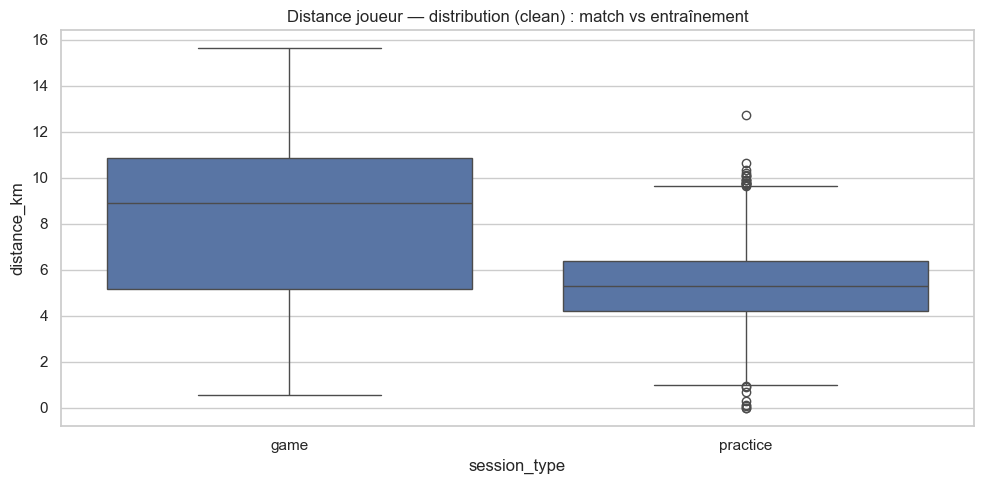

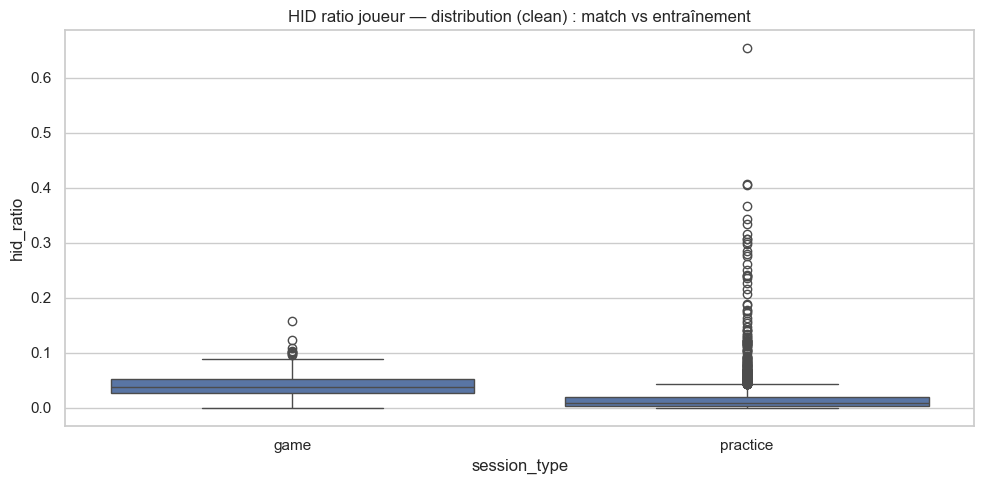

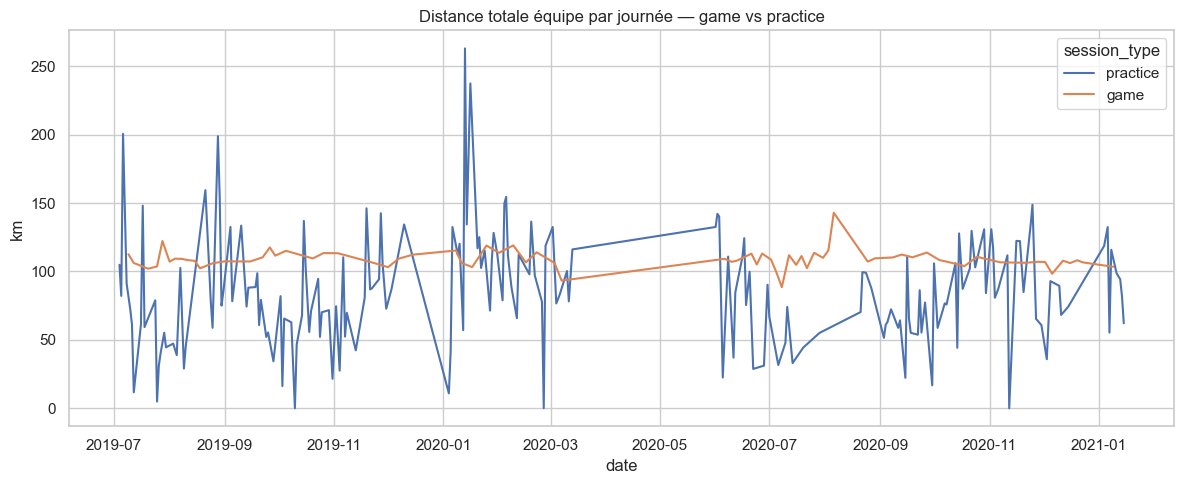

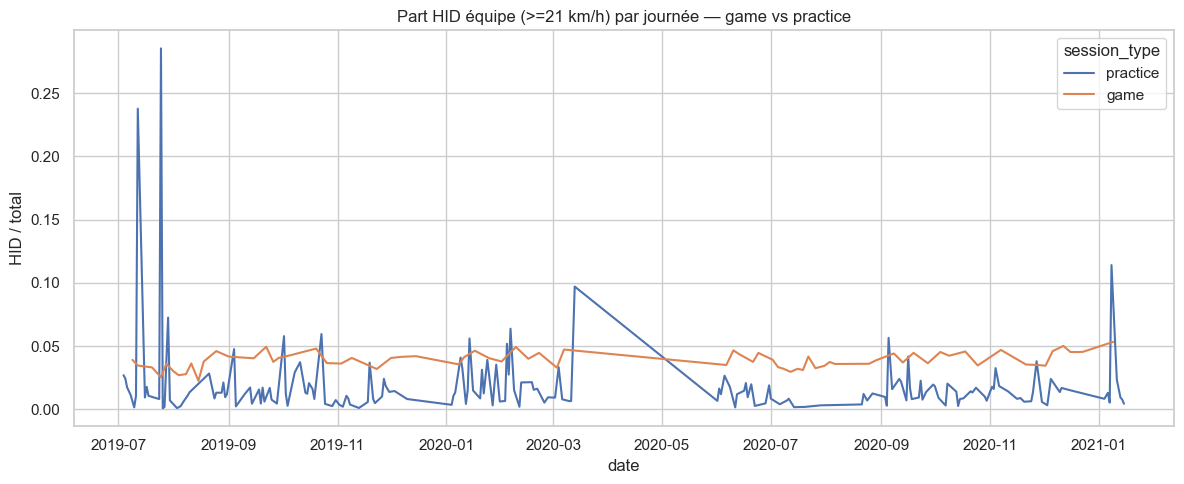

In [14]:
from IPython.display import display

# ---------------------------
# 5) SYNTHESE EQUIPE — DASHBOARD GLOBAL
# (basé sur summary_clean)
# ---------------------------

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

# A) Dataset "joueur-séance" clean, enrichi HID
team_rows = con.sql("""
SELECT
  date_trunc('day', session_ts)::DATE AS session_date,
  session_type,
  sensor,
  position,
  distance_km,
  max_speed_kmh,
  coalesce(acc_3mss,0) AS acc_3mss,
  coalesce(dec_3mss,0) AS dec_3mss,
  (coalesce(d_0_5_km,0) + coalesce(d_5_10_km,0) + coalesce(d_10_15_km,0) +
   coalesce(d_15_21_km,0) + coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) +
   coalesce(d_over30_km,0)) AS zones_sum_km,
  (coalesce(d_21_24_km,0) + coalesce(d_24_30_km,0) + coalesce(d_over30_km,0)) AS hid_km
FROM summary_clean
WHERE session_type IN ('game','practice')
  AND session_ts IS NOT NULL
  AND sensor IS NOT NULL;
""").df()

team_rows["hid_ratio"] = np.where(
    (team_rows["distance_km"].notna()) & (team_rows["distance_km"] > 0),
    team_rows["hid_km"] / team_rows["distance_km"],
    np.nan
)

# ---------------------------
# 1) Tableau global par type (game vs practice)
# ---------------------------
kpi_by_type = (
    team_rows
    .groupby("session_type", as_index=False)
    .agg(
        n_rows=("sensor", "count"),
        n_sensors=("sensor", "nunique"),
        n_days=("session_date", "nunique"),

        mean_distance_km=("distance_km", "mean"),
        median_distance_km=("distance_km", "median"),
        iqr_distance_km=("distance_km", iqr),

        mean_hid_km=("hid_km", "mean"),
        median_hid_km=("hid_km", "median"),
        iqr_hid_km=("hid_km", iqr),

        mean_hid_ratio=("hid_ratio", "mean"),
        median_hid_ratio=("hid_ratio", "median"),
        iqr_hid_ratio=("hid_ratio", iqr),

        mean_max_speed=("max_speed_kmh", "mean"),
        median_max_speed=("max_speed_kmh", "median"),
        iqr_max_speed=("max_speed_kmh", iqr),

        mean_acc=("acc_3mss", "mean"),
        median_acc=("acc_3mss", "median"),
        iqr_acc=("acc_3mss", iqr),

        mean_dec=("dec_3mss", "mean"),
        median_dec=("dec_3mss", "median"),
        iqr_dec=("dec_3mss", iqr),
    )
)

print("KPI globaux (joueur-séance) — game vs practice")
display(kpi_by_type)

# ---------------------------
# 2) Tableau par poste + type
# ---------------------------
kpi_by_type_position = (
    team_rows
    .groupby(["session_type", "position"], as_index=False)
    .agg(
        n_rows=("sensor", "count"),
        n_sensors=("sensor", "nunique"),

        mean_distance_km=("distance_km", "mean"),
        median_distance_km=("distance_km", "median"),
        iqr_distance_km=("distance_km", iqr),

        mean_hid_ratio=("hid_ratio", "mean"),
        median_hid_ratio=("hid_ratio", "median"),
        iqr_hid_ratio=("hid_ratio", iqr),

        mean_max_speed=("max_speed_kmh", "mean"),
        median_max_speed=("max_speed_kmh", "median"),
        iqr_max_speed=("max_speed_kmh", iqr),
    )
    .sort_values(["session_type", "median_distance_km"], ascending=[True, False])
)

print("KPI par poste + type")
display(kpi_by_type_position)

# ---------------------------
# 3) Synthèse équipe par journée (team load)
# ---------------------------
team_by_day = (
    team_rows
    .groupby(["session_type", "session_date"], as_index=False)
    .agg(
        n_players=("sensor", "nunique"),
        team_distance_km=("distance_km", "sum"),
        team_hid_km=("hid_km", "sum"),
        team_acc_3mss=("acc_3mss", "sum"),
        team_dec_3mss=("dec_3mss", "sum"),
        avg_player_max_speed=("max_speed_kmh", "mean"),
        max_player_max_speed=("max_speed_kmh", "max"),
    )
)

team_by_day["team_hid_ratio"] = team_by_day["team_hid_km"] / team_by_day["team_distance_km"].replace({0: np.nan})
team_by_day["session_date"] = pd.to_datetime(team_by_day["session_date"])

print("Top 5 journées (distance équipe) — game")
display(
    team_by_day[team_by_day["session_type"] == "game"]
    .sort_values("team_distance_km", ascending=False)
    .head(5)
)

print("Top 5 journées (distance équipe) — practice")
display(
    team_by_day[team_by_day["session_type"] == "practice"]
    .sort_values("team_distance_km", ascending=False)
    .head(5)
)

# ---------------------------
# Mini-dashboard visuel : distributions + intensité
# ---------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=team_rows, x="session_type", y="distance_km")
plt.title("Distance joueur — distribution (clean) : match vs entraînement")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=team_rows, x="session_type", y="hid_ratio")
plt.title("HID ratio joueur — distribution (clean) : match vs entraînement")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=team_by_day.sort_values("session_date"),
    x="session_date",
    y="team_distance_km",
    hue="session_type"
)
plt.title("Distance totale équipe par journée — game vs practice")
plt.ylabel("km")
plt.xlabel("date")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=team_by_day.sort_values("session_date"),
    x="session_date",
    y="team_hid_ratio",
    hue="session_type"
)
plt.title("Part HID équipe (>=21 km/h) par journée — game vs practice")
plt.ylabel("HID / total")
plt.xlabel("date")
plt.tight_layout()
plt.show()

## 6) Analyse individuelle — comparaison de deux joueurs (même rôle)

### Objectif
Cette section vise à **comparer deux joueurs occupant le même poste** sur l’ensemble de la période disponible, afin d’identifier des différences de profil athlétique et de comportements d’effort. L’analyse combine :
- une lecture **“valeurs brutes”** (pics, volumes, répartition des vitesses) ;
- une lecture **relative** via des **KPI normalisés par joueur**, c’est-à-dire interprétés par rapport à la variabilité habituelle de chacun (et séparément en match vs entraînement).

---

### Paramétrage (reproductible pour le club)
- **`MIN_SESSIONS`** : seuil minimal de séances par joueur pour être éligible à la comparaison.  
  Finalité : éviter des conclusions basées sur des échantillons trop faibles.

- **`TARGET_POSITION`** : poste cible, normalisé en **majuscule + suppression des espaces** (`upper(trim(...))`).  
  Remarque : dans les données, les postes sont de type texte (ex. *CENTER BACK*, *RIGHT BACK*, *CENTER MIDFIELD*). Si le poste fourni n’existe pas ou n’a pas assez de joueurs éligibles, le code bascule automatiquement vers le poste le plus représenté parmi les postes éligibles.

- **`SENSOR_A` / `SENSOR_B`** : identifiants des deux joueurs (capteurs).  
  Si ces valeurs ne sont pas renseignées, le code sélectionne automatiquement les **deux joueurs du poste** ayant le plus grand nombre de séances (comparaison robuste car mieux documentée).

---

### Identification des postes éligibles
Le code commence par construire un tableau `pos_eligible` :
1) comptage du nombre de séances par **capteur × poste** ;
2) filtrage sur `n_sessions >= MIN_SESSIONS` ;
3) agrégation par poste pour obtenir :
   - le nombre de joueurs éligibles,
   - le minimum / la moyenne / le maximum de séances disponibles.

Ce tableau sert de **contrôle qualité** (vérifier qu’au moins deux joueurs sont comparables sur un poste avec suffisamment de données). Si aucun poste n’est éligible, la seule action cohérente est de réduire `MIN_SESSIONS`.

---

### Sélection des deux joueurs au sein du même poste
Le tableau `cand_role` liste, pour le poste retenu :
- `n_sessions` total,
- `n_game` et `n_practice` (répartition match/entraînement).

L’objectif est double :
- garantir que **les deux joueurs appartiennent au même rôle** ;
- rendre la sélection traçable (table affichée) et contrôlable (sélection manuelle possible).

Une fonction d’étiquetage `plabel()` est ensuite utilisée pour afficher un libellé lisible (nom/prénom lorsque disponible, sinon capteur).

---

### Construction du dataset séance-par-séance (KPI)
Pour les deux capteurs sélectionnés, la requête extrait depuis `summary_clean` :
- **contexte** : date de séance, type de séance (*game* / *practice*), poste ;
- **charge externe** : `distance_km` ;
- **intensité/pics** : `avg_speed_kmh`, `max_speed_kmh`, `max_acc_ms2` ;
- **efforts intenses** : `acc_3mss` et `dec_3mss` (accélérations/décélérations ≥ 3 m/s²) ;
- **répartition des vitesses** : distances par zones (0–5, 5–10, …, >30 km/h).

À partir de ces variables, trois indicateurs dérivés sont calculés :

1) **HID (High Intensity Distance)**  
\[
$\text{hid\_km} = d_{21-24} + d_{24-30} + d_{>30}$
\]
et le **ratio HID** :
\[
$\text{hid\_ratio} = \frac{\text{hid\_km}}{\text{distance\_km}}$
\]
Interprétation : distinction entre **volume total** et **part relative d’intensité**.

2) **Densité d’efforts**  
\[
$\text{accdec\_total} = \text{acc\_3mss} + \text{dec\_3mss}$
\]
\[
$\text{accdec\_per\_km} = \frac{\text{accdec\_total}}{\text{distance\_km}}$
\]
Interprétation : mesure de “changements de rythme” (stop-and-go) **normalisée par km**, utile pour comparer des profils sans dépendre exclusivement des sprints.

---

### Profil 1 — Relation accélération ↔ vitesse (par séance)
Un nuage de points compare :
- en abscisse : `max_speed_kmh`
- en ordonnée : `max_acc_ms2`
- couleur : joueur
- style : type de séance (match vs entraînement)

Finalité : situer chaque joueur sur un axe “capacité à atteindre des pics de vitesse” et “capacité à produire des pics d’accélération”, tout en observant la différence de comportement entre match et entraînement.

---

### Profil 2 — Distribution des vitesses (répartition par zones)
Pour chaque séance, la part de distance dans chaque zone est calculée :
\[
$\text{share}_{zone} = \frac{d_{zone}}{\text{distance\_km}}$
\]
Puis ces parts sont moyennées par joueur et par type de séance. Les graphiques produits permettent :
- une comparaison globale (moyenne toutes séances),
- puis une comparaison **séparée** match vs entraînement (contextes d’intensité différents).

Finalité : caractériser un joueur “volume basse intensité” vs “volume haute intensité”, indépendamment de la quantité totale de distance.

---

### Profil 3 — Densité d’efforts (accélérations + décélérations par km)
Un boxplot compare `accdec_per_km` :
- entre match et entraînement,
- entre les deux joueurs.

Un tableau récapitulatif donne également les médianes (par type de séance) et le nombre de séances contribuant au calcul.  
Finalité : mettre en évidence un profil plus “intermittent / changements de rythme” vs plus “linéaire”, et vérifier si l’écart se renforce en match.

---

### KPI normalisés par joueur (z-scores) et heatmaps
Pour éviter de comparer uniquement des valeurs brutes (souvent dépendantes du rôle exact, du temps de jeu, du contexte), le code calcule des **z-scores par joueur et par type de séance** :

\[
$z = \frac{x - \mu}{\sigma}$
\]

- Calcul séparé pour *game* et *practice* : cela évite de mélanger des distributions naturellement différentes.
- Les z-scores sont ensuite résumés (médiane) par joueur et affichés en **heatmap**.

Interprétation :
- un z-score positif indique une valeur **au-dessus** du niveau habituel du joueur dans ce contexte ;
- un z-score négatif indique une valeur **en dessous** ;
- la heatmap permet de visualiser rapidement sur quelles dimensions chaque joueur “se distingue” relativement à sa propre norme (distance, intensité, accélérations/décélérations, densité d’efforts, etc.).


Postes éligibles (au moins 2 joueurs recommandés) :


,position,n_sensors_eligible,min_sessions,avg_sessions,max_sessions
0,CENTER FORWARD,6,41,117.166667,143
1,CENTER MIDFIELD,5,43,115.000000,177
2,LEFT FORWARD,5,42,108.000000,203
3,CENTER BACK,4,94,165.500000,222
4,RIGHT BACK,4,83,109.250000,160
5,LEFT BACK,4,44,100.750000,205
6,RAN CENTER,1,181,181.000000,181
7,ORIK CENTER,1,143,143.000000,143
8,ILIP CENTER,1,69,69.000000,69
9,RIGHT MIDFIELD,1,57,57.000000,57


⚠️ TARGET_POSITION='DEF' introuvable/insuffisant. Je bascule sur 'CENTER FORWARD'.
Candidats éligibles — position=CENTER FORWARD (MIN_SESSIONS=30)


,sensor,position,n_sessions,n_game,n_practice,last_name,first_name
0,10,CENTER FORWARD,143,39.0,104.0,ELEKE,BLESSING
1,28,CENTER FORWARD,141,24.0,117.0,TIA,CHEF
2,20,CENTER FORWARD,135,27.0,108.0,DEMHASAJ,MIMI
3,21,CENTER FORWARD,124,29.0,95.0,MALES,DARIAN
4,77,CENTER FORWARD,119,32.0,87.0,RYDER,MATOS
5,16,CENTER FORWARD,41,3.0,38.0,RYDER,MATOS


Auto-pick (même rôle): 10 28
Joueur A: ELEKE BLESSING (10)
Joueur B: TIA CHEF (28)


,session_date,session_type,sensor,position,distance_km,avg_speed_kmh,max_speed_kmh,max_acc_ms2,acc_3mss,dec_3mss,...,d_10_15_km,d_15_21_km,d_21_24_km,d_24_30_km,d_over30_km,player,hid_km,hid_ratio,accdec_total,accdec_per_km
0,2019-07-04,practice,10,CENTER FORWARD,4.56,4.82,18.94,3.69,16.0,14.0,...,0.35,0.05,0.00,0.00,0.0,ELEKE BLESSING (10),0.00,0.000000,30.0,6.578947
1,2019-07-04,practice,28,CENTER FORWARD,5.01,4.68,19.34,4.11,24.0,9.0,...,0.46,0.16,0.00,0.00,0.0,TIA CHEF (28),0.00,0.000000,33.0,6.586826
2,2019-07-05,practice,28,CENTER FORWARD,6.53,4.09,27.55,5.12,76.0,36.0,...,0.94,0.63,0.20,0.03,0.0,TIA CHEF (28),0.23,0.035222,112.0,17.151608
3,2019-07-06,practice,10,CENTER FORWARD,8.36,4.96,25.22,5.53,121.0,54.0,...,1.20,1.09,0.08,0.01,0.0,ELEKE BLESSING (10),0.09,0.010766,175.0,20.933014
4,2019-07-06,practice,28,CENTER FORWARD,10.66,5.50,27.61,4.81,149.0,85.0,...,1.92,2.04,0.25,0.04,0.0,TIA CHEF (28),0.29,0.027205,234.0,21.951220
5,2019-07-08,practice,28,CENTER FORWARD,4.27,3.13,24.58,4.17,24.0,11.0,...,0.43,0.19,0.07,0.01,0.0,TIA CHEF (28),0.08,0.018735,35.0,8.196721
6,2019-07-08,practice,10,CENTER FORWARD,4.38,3.32,24.22,4.74,29.0,14.0,...,0.33,0.25,0.06,0.01,0.0,ELEKE BLESSING (10),0.07,0.015982,43.0,9.817352
7,2019-07-09,game,10,CENTER FORWARD,8.03,7.05,28.29,5.02,56.0,62.0,...,1.99,0.83,0.22,0.13,0.0,ELEKE BLESSING (10),0.35,0.043587,118.0,14.694894
8,2019-07-09,game,28,CENTER FORWARD,3.43,7.57,28.95,4.90,31.0,50.0,...,0.99,0.53,0.11,0.10,0.0,TIA CHEF (28),0.21,0.061224,81.0,23.615160
9,2019-07-10,practice,28,CENTER FORWARD,4.83,4.07,24.32,5.14,70.0,53.0,...,0.87,0.28,0.02,0.00,0.0,TIA CHEF (28),0.02,0.004141,123.0,25.465839


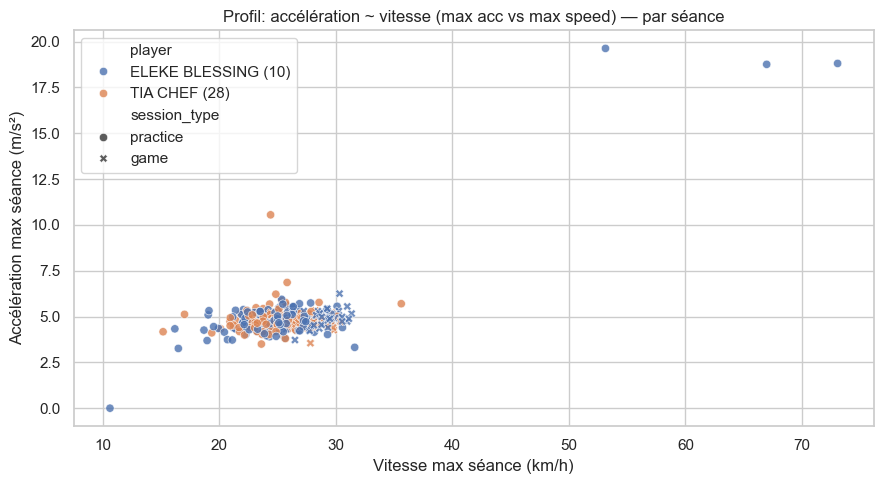

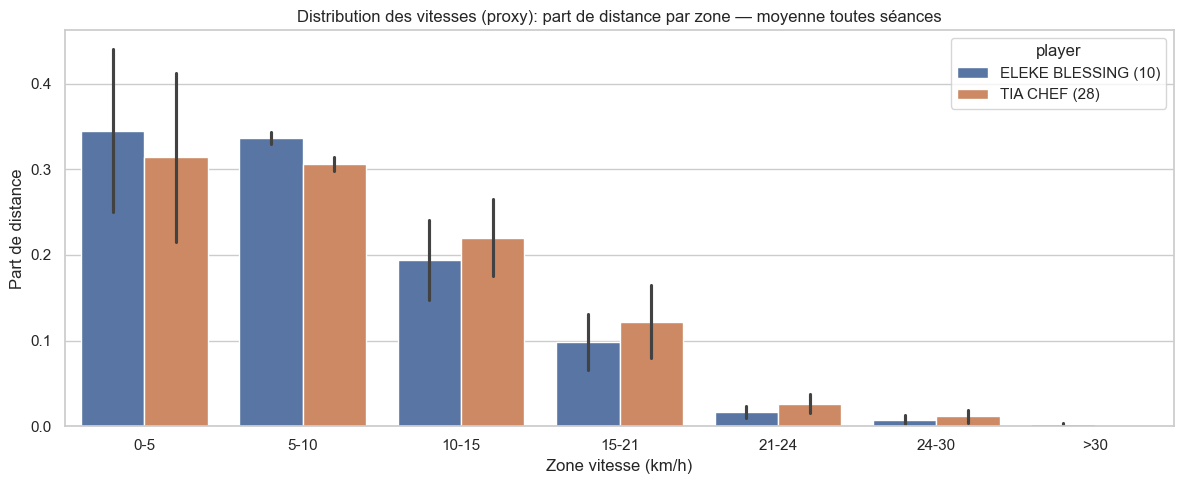

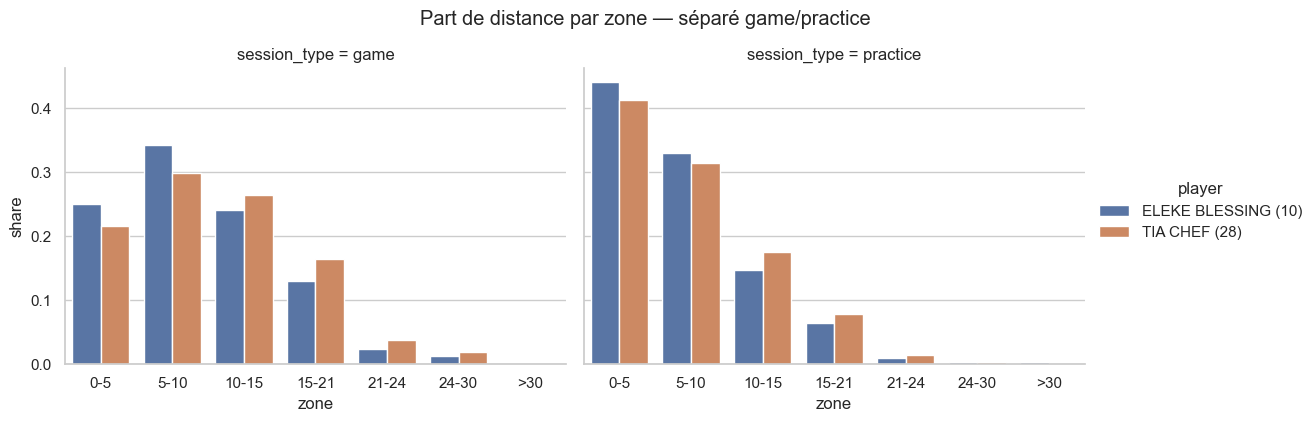

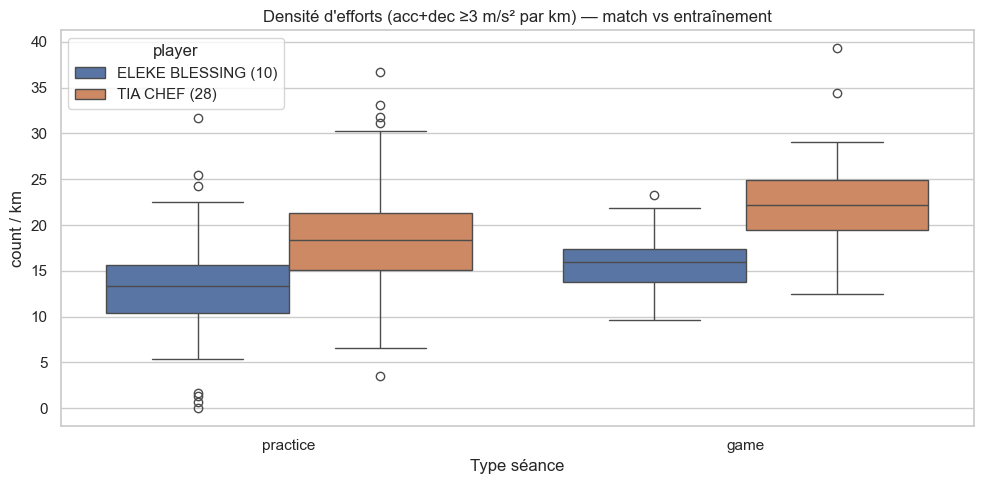

Résumé densité d'efforts :


,player,session_type,n_sessions,median_accdec_per_km,median_accdec_total
0,ELEKE BLESSING (10),game,57,15.980630,99.0
1,ELEKE BLESSING (10),practice,136,13.301019,73.5
2,TIA CHEF (28),game,24,22.191215,62.0
3,TIA CHEF (28),practice,117,18.346253,104.0


,session_type,player,z_distance_km,z_hid_km,z_hid_ratio,z_max_speed_kmh,z_max_acc_ms2,z_acc_3mss,z_dec_3mss,z_accdec_per_km
0,game,ELEKE BLESSING (10),-0.073319,-0.329318,0.011281,0.164304,0.020983,-0.014488,-0.199249,0.110259
1,game,TIA CHEF (28),-0.206758,-0.309659,0.152484,0.114133,-0.041120,-0.200716,-0.209004,-0.061553
2,practice,ELEKE BLESSING (10),-0.024912,-0.170419,-0.187743,-0.106173,-0.132439,-0.113055,-0.054802,-0.000730
3,practice,TIA CHEF (28),0.048958,-0.277773,-0.239394,-0.010758,-0.094337,-0.108227,-0.043444,0.013766


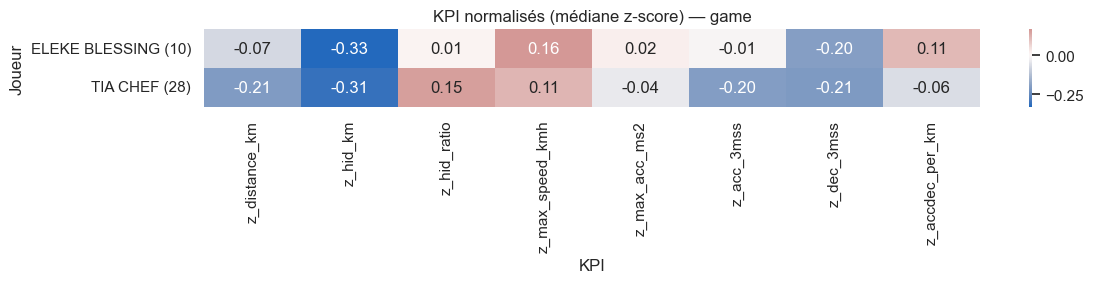

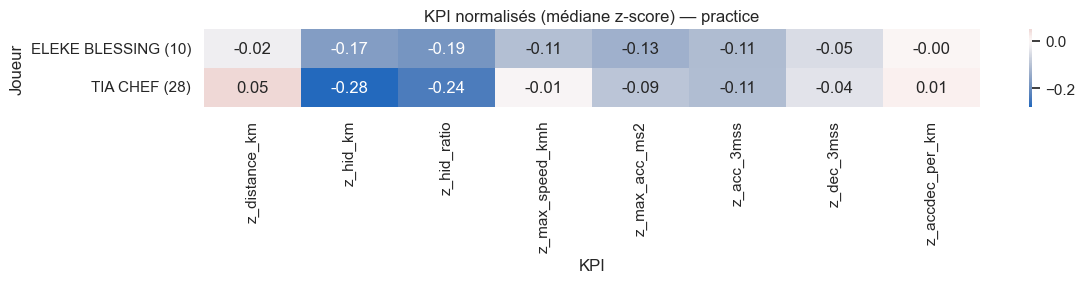

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set_theme(style="whitegrid")

# ---------------------------
# 6) COMPARAISON 2 JOUEURS — MÊME RÔLE 
# ---------------------------

# ---------------------------
# Paramètres (club)
# ---------------------------
MIN_SESSIONS = 30

# Poste/role cible (sera normalisé en UPPER + trim)
# Exemple de valeurs réelles dans tes données : "CENTER BACK", "CENTER MIDFIELD", "RIGHT BACK", ...
TARGET_POSITION = "DEF"   # si invalide, le code bascule sur le poste le plus représenté éligible

# Choix des 2 joueurs du même rôle :
# - mets des entiers si tu veux forcer
# - laisse None pour prendre les 2 meilleurs du rôle
SENSOR_A = None
SENSOR_B = None

# ---------------------------
# 0) Tableau des postes disponibles et "éligibles"
#    (au moins 2 joueurs avec >= MIN_SESSIONS)
# ---------------------------
players_df = con.sql("SELECT * FROM players").df()

pos_eligible = con.execute("""
WITH per_sensor AS (
  SELECT
    sensor,
    upper(trim(position)) AS position_norm,
    COUNT(*) AS n_sessions
  FROM summary_clean
  WHERE sensor IS NOT NULL AND position IS NOT NULL
  GROUP BY 1, 2
),
eligible AS (
  SELECT *
  FROM per_sensor
  WHERE n_sessions >= ?
)
SELECT
  position_norm AS position,
  COUNT(*) AS n_sensors_eligible,
  MIN(n_sessions) AS min_sessions,
  AVG(n_sessions) AS avg_sessions,
  MAX(n_sessions) AS max_sessions
FROM eligible
GROUP BY 1
ORDER BY n_sensors_eligible DESC, avg_sessions DESC;
""", [MIN_SESSIONS]).fetchdf()

print("Postes éligibles (au moins 2 joueurs recommandés) :")
display(pos_eligible)

if len(pos_eligible) == 0:
    raise ValueError("Aucun poste n'a de joueurs avec MIN_SESSIONS. Baisse MIN_SESSIONS (ex: 15/20).")

# Si TARGET_POSITION invalide -> on bascule sur le poste le plus représenté éligible
target_norm = str(TARGET_POSITION).strip().upper()
if target_norm not in set(pos_eligible["position"].tolist()):
    best_pos = pos_eligible.iloc[0]["position"]
    print(f"⚠️ TARGET_POSITION='{TARGET_POSITION}' introuvable/insuffisant. Je bascule sur '{best_pos}'.")
    target_norm = best_pos

# ---------------------------
# 1) Candidats du même rôle (pour sélectionner A et B)
# ---------------------------
cand_role = con.execute("""
SELECT
  sensor,
  upper(trim(any_value(position))) AS position,
  COUNT(*) AS n_sessions,
  SUM(CASE WHEN session_type='game' THEN 1 ELSE 0 END) AS n_game,
  SUM(CASE WHEN session_type='practice' THEN 1 ELSE 0 END) AS n_practice
FROM summary_clean
WHERE sensor IS NOT NULL
  AND position IS NOT NULL
  AND upper(trim(position)) = ?
GROUP BY sensor
HAVING COUNT(*) >= ?
ORDER BY n_sessions DESC, n_game DESC, n_practice DESC;
""", [target_norm, MIN_SESSIONS]).fetchdf()

cand_role = cand_role.merge(players_df, on="sensor", how="left")

print(f"Candidats éligibles — position={target_norm} (MIN_SESSIONS={MIN_SESSIONS})")
display(cand_role)

if len(cand_role) < 2:
    raise ValueError("Pas assez de joueurs éligibles pour ce poste. Baisse MIN_SESSIONS ou choisis un autre poste dans pos_eligible.")

# Auto-pick si pas forcé : 2 meilleurs du rôle
if SENSOR_A is None or SENSOR_B is None:
    SENSOR_A = int(cand_role.iloc[0]["sensor"])
    SENSOR_B = int(cand_role.iloc[1]["sensor"])
    print("Auto-pick (même rôle):", SENSOR_A, SENSOR_B)

SENSOR_A = int(SENSOR_A)
SENSOR_B = int(SENSOR_B)

eligible_sensors = set(cand_role["sensor"].dropna().astype(int).tolist())
if SENSOR_A not in eligible_sensors or SENSOR_B not in eligible_sensors:
    raise ValueError("SENSOR_A/SENSOR_B ne sont pas dans la liste des candidats éligibles (cand_role).")

def plabel(sensor: int) -> str:
    r = cand_role[cand_role["sensor"].astype(int) == int(sensor)]
    if len(r):
        r = r.iloc[0]
        return f"{r.get('last_name','?')} {r.get('first_name','?')} ({int(sensor)})"
    return f"({int(sensor)})"

print("Joueur A:", plabel(SENSOR_A))
print("Joueur B:", plabel(SENSOR_B))

# ---------------------------
# 2) Dataset KPI (summary_clean) pour ces 2 joueurs
# ---------------------------
df = con.execute("""
SELECT
  date_trunc('day', session_ts)::DATE AS session_date,
  session_type,
  sensor,
  upper(trim(position)) AS position,

  distance_km,
  avg_speed_kmh,
  max_speed_kmh,
  max_acc_ms2,

  coalesce(acc_3mss,0) AS acc_3mss,
  coalesce(dec_3mss,0) AS dec_3mss,

  coalesce(d_0_5_km,0) AS d_0_5_km,
  coalesce(d_5_10_km,0) AS d_5_10_km,
  coalesce(d_10_15_km,0) AS d_10_15_km,
  coalesce(d_15_21_km,0) AS d_15_21_km,
  coalesce(d_21_24_km,0) AS d_21_24_km,
  coalesce(d_24_30_km,0) AS d_24_30_km,
  coalesce(d_over30_km,0) AS d_over30_km
FROM summary_clean
WHERE sensor IN (?, ?)
  AND session_ts IS NOT NULL
  AND distance_km IS NOT NULL
ORDER BY session_date;
""", [SENSOR_A, SENSOR_B]).fetchdf()

df["session_date"] = pd.to_datetime(df["session_date"])
df["sensor"] = df["sensor"].astype(int)
df["player"] = df["sensor"].map(plabel)

# HID
df["hid_km"] = df["d_21_24_km"] + df["d_24_30_km"] + df["d_over30_km"]
df["hid_ratio"] = np.where(df["distance_km"] > 0, df["hid_km"] / df["distance_km"], np.nan)

# NOUVEAU METRIC (remplace sprint/repetition) :
# "densité de changements de rythme" = (acc + dec >=3 m/s²) / km
df["accdec_total"] = df["acc_3mss"] + df["dec_3mss"]
df["accdec_per_km"] = np.where(df["distance_km"] > 0, df["accdec_total"] / df["distance_km"], np.nan)

display(df.head(10))

# ---------------------------
# 3) Profil 1 — Accélération ~ vitesse (proxy séance)
# ---------------------------
plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=df,
    x="max_speed_kmh",
    y="max_acc_ms2",
    hue="player",
    style="session_type",
    alpha=0.8,
)
plt.title("Profil: accélération ~ vitesse (max acc vs max speed) — par séance")
plt.xlabel("Vitesse max séance (km/h)")
plt.ylabel("Accélération max séance (m/s²)")
plt.tight_layout()
plt.show()

# ---------------------------
# 4) Profil 2 — Distribution des vitesses (via zones)
# ---------------------------
zones = ["d_0_5_km","d_5_10_km","d_10_15_km","d_15_21_km","d_21_24_km","d_24_30_km","d_over30_km"]
zone_labels = ["0-5","5-10","10-15","15-21","21-24","24-30",">30"]

for z in zones:
    df[f"share_{z}"] = np.where(df["distance_km"] > 0, df[z] / df["distance_km"], np.nan)

share_cols = [f"share_{z}" for z in zones]
share_mean = df.groupby(["player","session_type"], as_index=False)[share_cols].mean()

plot_rows = []
for _, r in share_mean.iterrows():
    for z, lab in zip(zones, zone_labels):
        plot_rows.append({
            "player": r["player"],
            "session_type": r["session_type"],
            "zone": lab,
            "share": r[f"share_{z}"],
        })
share_long = pd.DataFrame(plot_rows)

plt.figure(figsize=(12, 5))
sns.barplot(data=share_long, x="zone", y="share", hue="player")
plt.title("Distribution des vitesses (proxy): part de distance par zone — moyenne toutes séances")
plt.xlabel("Zone vitesse (km/h)")
plt.ylabel("Part de distance")
plt.tight_layout()
plt.show()

g = sns.catplot(
    data=share_long,
    x="zone", y="share",
    col="session_type",
    hue="player",
    kind="bar",
    height=4, aspect=1.4
)
g.fig.suptitle("Part de distance par zone — séparé game/practice", y=1.05)
plt.show()

# ---------------------------
# 5) Profil 3 — Densité d'efforts (remplace sprint)
# ---------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="session_type", y="accdec_per_km", hue="player")
plt.title("Densité d'efforts (acc+dec ≥3 m/s² par km) — match vs entraînement")
plt.xlabel("Type séance")
plt.ylabel("count / km")
plt.tight_layout()
plt.show()

dens = (
    df.groupby(["player","session_type"], as_index=False)
      .agg(
          n_sessions=("session_date","count"),
          median_accdec_per_km=("accdec_per_km","median"),
          median_accdec_total=("accdec_total","median"),
      )
)
print("Résumé densité d'efforts :")
display(dens)

# ---------------------------
# 6) KPI normalisés par joueur (z-scores) + heatmaps
# ---------------------------
kpi_cols = [
    "distance_km", "hid_km", "hid_ratio",
    "max_speed_kmh", "max_acc_ms2",
    "acc_3mss", "dec_3mss",
    "accdec_per_km"
]

def zscore(x):
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if (not np.isfinite(sd)) or sd == 0:
        return x * np.nan
    return (x - mu) / sd

for col in kpi_cols:
    df[f"z_{col}"] = df.groupby(["player","session_type"])[col].transform(zscore)
    df[f"pct_{col}"] = df.groupby(["player","session_type"])[col].transform(lambda s: s.rank(pct=True))

zcols = [f"z_{c}" for c in kpi_cols]
rel = df.groupby(["session_type","player"], as_index=False)[zcols].median()
display(rel)

for st in sorted(df["session_type"].dropna().unique()):
    tmp = rel[rel["session_type"] == st].set_index("player")[zcols]
    plt.figure(figsize=(12, 3))
    sns.heatmap(tmp, annot=True, fmt=".2f", center=0, cmap="vlag")
    plt.title(f"KPI normalisés (médiane z-score) — {st}")
    plt.xlabel("KPI")
    plt.ylabel("Joueur")
    plt.tight_layout()
    plt.show()

## Conclusion générale

Ce projet a permis de construire un outil de monitoring de performance exploitable en contexte club à partir de données GPS/IMU, avec une approche orientée “production” : centralisation des séances, standardisation des KPI et contrôle de la qualité des données avant toute interprétation. L’utilisation de DuckDB et d’une vue nettoyée (`summary_clean`) fournit un socle robuste et reproductible pour interroger l’historique en SQL et produire des sorties cohérentes (tables et graphiques) destinées au staff.

Sur le plan analytique, le notebook met en évidence la complémentarité indispensable entre **volume** (distance totale), **intensité** (HID et ratio HID), **exposition à la vitesse** (vitesses max, zones), et **densité d’efforts** (accélérations/décélérations). La comparaison structurée match vs entraînement, ainsi que l’emploi de KPI “par joueur” et de mesures de variabilité (percentiles, CV) permettent de situer la charge d’entraînement par rapport aux exigences du match et d’évaluer la stabilité de la planification. Enfin, le volet individuel (comparaison de deux joueurs au même poste) illustre l’intérêt d’une lecture normalisée (z-scores) : elle replace les performances dans le référentiel habituel de chaque joueur et limite les conclusions biaisées par les différences de contexte.

Les résultats doivent toutefois être interprétés avec prudence : les analyses sont fondées sur des KPI agrégés “joueur–séance” et ne décrivent pas la dynamique intra-séance (phases, séquences répétées), qui nécessiterait l’exploitation complète du tracking brut. De plus, l’effectif présent influence fortement les agrégations collectives, et la charge externe ne remplace pas une charge interne si elle est disponible (RPE, fréquence cardiaque). Dans ces conditions, ce notebook constitue une base solide pour un suivi régulier et comparable de la charge, et ouvre naturellement vers des prolongements : intégration du tracking brut pour des analyses temporelles, et enrichissement par des indicateurs internes pour une lecture plus complète du risque et de la récupération.